In [6]:
#! pip install bertopic
# ! pip install "tensorflow>=2.0.0"
# ! pip install --upgrade tensorflow-hub
# ! pip install transformers
# ! pip install torch
#! pip install pyLDAvis
#! pip install --upgrade pandas numpy matplotlib
#! pip install scikit-surprise
# ! pip install google-api-core
# ! pip install google-cloud-dialogflow
#! pip install textblob
#! pip install futures
#! pip install spacy_langdetect
# !pip install -qU langchain
# !pip install -qU openai
# ! pip install umap
# ! pip install pyLDAvis
# ! pip install sentence_transformers
! pip install scikit-learn fuzzywuzzy pandas
# ! pip install datatable
# ! pip install langdetect
# ! pip install bertopic
# ! pip install keybert
# ! pip install spacytextblob

In [1]:
#the raw data is saved under this directory "My Drive/Colab Notebooks/chatbot"
from google.colab import drive
drive.mount('/content/drive')
data_root = '/content/drive/My Drive/Colab Notebooks/chatbot'

Mounted at /content/drive


In [11]:
# -*- coding: utf-8 -*-

#import the libraries and declare settings
import os
# import requests
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re
import string
#import json
import random
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict  # For word frequency
# from gensim.models import Word2Vec
#from gensim.models.phrases import Phrases, Phraser
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import multiprocessing
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import Counter
# import tensorflow_hub as hub
# import tensorflow as tf
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense, Dropout
import torch
from transformers import BertTokenizer, BertModel
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import urllib.request as urllib2
#language detect
from langdetect import detect
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
import spacy
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import multidict as multidict
import wordcloud
from wordcloud import WordCloud
import warnings
import datatable as dt
#classification
#import swifter
#from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from spacytextblob.spacytextblob import SpacyTextBlob
from tqdm import tqdm
#text clustering
from scipy.spatial.distance import cosine
from scipy.spatial.distance import correlation
from scipy.stats import pearsonr
from fuzzywuzzy import fuzz
from keybert import KeyBERT
from transformers import pipeline
from bertopic import BERTopic
from bertopic.dimensionality import BaseDimensionalityReduction
from gensim.models import LdaModel, CoherenceModel
from umap import UMAP
from sklearn.decomposition import PCA
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
from sentence_transformers import SentenceTransformer
#pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)
pd.set_option('display.width', 100000)

In [ ]:
# download files for text cleaning
nltk.download('punkt')
nltk.download('stopwords')
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#text cleaning function
def text_cleaning(text, flg_lemm=True, flg_stemm=False):
    # lower case
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove all the contents which are not letters, i.e, remove all the punctuations/numbers
    # Get the alphabetic words that have 3 or more letters
    text = re.findall(r"[a-zA-Z]{3,}", text)
    # Convert to lowercase to uniform the words
    words = [word.lower() for word in text if word.isalnum()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Remove most meaningless frequent words
    my_remove_words = ['hostel','would','like']
    words = [word for word in words if word not in my_remove_words]
    # Lemmatize the words
    if flg_lemm == True:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    # Stemming the words, we found stemming doesn't improve the model accuracy (such as SVM)
    if flg_stemm == True:
        stemmer = nltk.stem.porter.PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    #clean_text = ' '.join(words)
    return words

In [119]:
#define function of visualization - word cloud and freqnuency bar charts
# the functions make it's possible to create charts based on different dimensions, such as nationality, age, gender...
def fun_freqent_ngram(df, top=10, n=2, num_columns=1, my_char='user_nationality_name', my_text='clean_text'):
    select_char = df[my_char].unique()
    num_rows = (len(select_char) + num_columns - 1) // num_columns
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

    for i, j in enumerate(select_char):
        row_position = i // num_columns
        col_position = i % num_columns
        char_texts = df[df[my_char] == j][my_text].astype(str).str.cat(sep=' ')  # Join text from selected char
        vectorizer = CountVectorizer(ngram_range=(n, n))
        ngrams_matrix = vectorizer.fit_transform([char_texts])  # Pass a list of texts to fit_transform
        ngrams_list = vectorizer.get_feature_names_out()
        # Sum up n-gram occurrences
        ngrams_count = ngrams_matrix.sum(axis=0)
        # Create a Counter for n-grams
        ngrams_counter = Counter(dict(zip(ngrams_list, ngrams_count.A1)))
        sorted_ngrams = dict(sorted(ngrams_counter.items(), key=lambda x: x[1], reverse=True))
        # Plot frequency chart, top 10
        axs[row_position].barh(*zip(*list(sorted_ngrams.items())[:top][::-1]))
        axs[row_position].set_title(f'Frequency Chart for {j}')
        axs[row_position].set_xlabel('Frequency')
        axs[row_position].set_ylabel(f'{n}-gram')

    plt.tight_layout()
    plt.show()

#wordcloud
# Function to get frequency dictionary for text
def getFrequencyDictForText(sentence):
    stop_words = set(["a", "the", "an", "to", "in", "for", "of", "or", "by", "with", "is", "on", "that", "be"])
    word_freq = {}
    for word in re.findall(r'\b\w+\b', sentence):
        if word.lower() not in stop_words:
            word_freq[word.lower()] = word_freq.get(word.lower(), 0) + 1
    return word_freq

# Function to generate word cloud image
def makeImage(text):
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Function to create word cloud based on frequency
def word_cloud_frequency(df, my_char='user_nationality_name', my_text='clean_text'):
    unique_values = df[my_char].unique()
    for value in unique_values:
        print(f"{my_char}: {value}")
        text_data = df[df[my_char] == value][my_text].astype(str).str.cat(sep=' ')
        text_data = text_data.strip()
        freq_dict = getFrequencyDictForText(text_data)
        makeImage(freq_dict)

In [143]:
#10 fold cross validation'
def tenF_crossval(df, my_model):
    non_features = ['name', 'type', 'starRating', 'city.name', 'city.country', 'address', 'review_date',
                    'review_comment', 'user_gender_code', 'user_age', 'user_trip_code', 'user_nationality_name',
                    'avg_score', 'review_rating_overall', 'sentiment_label', 'Language2', 'clean_text', 'combined_label']
    x = df.drop(non_features, axis=1)
    y = df['sentiment_label']
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
# Use cross_val_score to get accuracy scores for each fold
    accuracy_scores = cross_val_score(my_model, x, y, cv=kf, scoring='accuracy')
#print the accuracy scores for each fold
    formatted_scores = [format(score, '.3f') for score in accuracy_scores]
    print("Accuracy scores for each fold:", formatted_scores)
# Calculate and display the mean accuracy across all folds
    mean_accuracy = np.mean(accuracy_scores)
    print('Mean score of all folds: {:.3f}'.format(mean_accuracy))

In [ ]:
# our datasets are found on Kaggle, we looked into different datasets and determin which one is better for our analysis
#read raw data, first dataset (https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe)
data = pd.read_csv(data_root + '/Hotel_Reviews.csv')
data.shape

(515738, 17)

In [ ]:
#take a look at the content of the data
print(data.head())
print(data.tail())

                                       Hotel_Address  Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name Reviewer_Nationality                                    Negative_Review  Review_Total_Negative_Word_Counts  Total_Number_of_Reviews                                    Positive_Review  Review_Total_Positive_Word_Counts  Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score                                               Tags days_since_review        lat       lng
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...                           194    8/3/2017            7.7  Hotel Arena              Russia    I am so angry that i made this post available...                                397                     1403   Only the park outside of the hotel was beauti...                                 11                                           7             2.9  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days  52.360576  4.915968
1   s Gravesandest

In [ ]:
#combine positive, negative review, review_date
# replace 'No Negative' and 'No Positive' to an empty string
data['Positive_Review'] = data['Positive_Review'].replace('No Positive', '')
data['Negative_Review'] = data['Negative_Review'].replace('No Negative', '')
data['review_text'] = data['Positive_Review'].str.cat(data['Negative_Review'], sep=' ')
data['review_date'] = pd.to_datetime(data['Review_Date'], format='%m/%d/%Y')

In [ ]:
data['review_date'].agg(['min', 'max'])
# the dataset is not the latest

min   2015-08-04
max   2017-08-03
Name: review_date, dtype: datetime64[ns]

In [ ]:
# the second dataset, source: https://www.kaggle.com/datasets/felipejardimf/hotel-reviews-hostelworld?select=hostel_review_data.csv
# read raw data
data_hotel = pd.read_csv(data_root + '/hotel_detail_data.csv',sep=';')
data_review = pd.read_csv(data_root + '/hostel_review_data.csv',sep=';')

In [ ]:
print(data_hotel.columns)
print(data_hotel.shape)

Index(['id_hostel', 'name', 'currency', 'type', 'maxNumberOfGuestsPerBooking', 'isFeatured', 'latestCheckOut', 'rating', 'totalRatings', 'starRating', 'facilities', 'description', 'latitude', 'longitude', 'address1', 'address2', 'directions', 'depositPercentage', 'checkIn.startsAt', 'checkIn.endsAt', 'city.id', 'city.name', 'city.country', 'city.idCountry', 'region.id', 'region.name', 'payments.payNow', 'cancellationPolicy.depositOnly.description', 'cancellationPolicy.depositOnly.numberOfDays', 'cancellationPolicy.nonRefundable.description', 'cancellationPolicy.freeCancellation.description', 'freeCancellation.isAvailable', 'freeCancellation.daysInAdvance', 'groupInformation.groupMaxPax', 'taxInfo.included', 'taxInfo.taxes'], dtype='object')
(41642, 36)


In [ ]:
print(data_review.columns)
print(data_review.shape)

Index(['id_review', 'id_hostel', 'id_user', 'review_date', 'review_comment', 'review_owner_comment', 'user_gender_code', 'user_gender_code_2', 'user_age', 'user_trip_code', 'user_nationality_code', 'user_nationality_name', 'user_number_reviews', 'review_rating', 'review_safety_rate', 'review_location_rate', 'review_staff_rate', 'review_atmosphere_rate', 'review_cleanliness_rate', 'review_facilities_rate', 'review_rating_overall'], dtype='object')
(934212, 21)


In [ ]:
#select columns we need
hotel_info = data_hotel[['id_hostel', 'name', 'type','totalRatings', 'starRating','address1', 'address2','city.name', 'city.country']]
hotel_review = data_review[['id_hostel','review_date', 'review_comment', 'user_gender_code', 'user_age', 'user_trip_code',
                            'user_nationality_name', 'user_number_reviews',
                            'review_safety_rate', 'review_location_rate', 'review_staff_rate', 'review_atmosphere_rate', 'review_cleanliness_rate',
                            'review_facilities_rate', 'review_rating_overall']]

In [ ]:
#combine two dataset by "id_hostel" to get reviews from hotel_review and hotel information from hotel_info
hotel_info['address'] = hotel_info['address2'].str.cat(hotel_info['address1'], sep=', ')
hotel_info = hotel_info.drop(['address2', 'address1'], axis=1)
my_df = pd.merge(hotel_info, hotel_review, on='id_hostel', how='inner')
my_df.shape

(934054, 22)

In [ ]:
my_df.head()

id_hostel             name   type  totalRatings  starRating  city.name city.country                                            address review_date                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name  user_number_reviews  review_safety_rate  review_location_rate  review_staff_rate  review_atmosphere_rate  review_cleanliness_rate  review_facilities_rate  review_rating_overall
0     102883  Riad Dar Attika  HOTEL            59           0  Marrakech      Morocco  Medina, Marrakech, Riad Zitoun Jdid Derb Tlitl...  2022-05-12  Leuke en veilige plek, aardig personeel en net...           FEMALE    25-30     COLLEGEBREAK           Netherlands                    6                 100                   100                 80                      80                       80                      80                     86
1     102883  Riad Dar Attika  HOTEL            59           0  Marrakech      Morocco  Medina, Marrakech, Riad Zitoun Jdid Derb Tlitl...  2024-01-09  Increíble lugar. Muy cerca de atractivos turís...           COUPLE    31-40          RTWTRIP                Mexico                   10                 100                   100                100                      80                      100                     100                     97
2     102883  Riad Dar Attika  HOTEL            59           0  Marrakech      Morocco  Medina, Marrakech, Riad Zitoun Jdid Derb Tlitl...  2024-01-08  Otima estadia!!! Riad muito limpo, organizado ...           COUPLE    31-40  REGULARVACATION                Brazil                    3                 100                   100                100                     100                      100                     100                    100
3     102883  Riad Dar Attika  HOTEL            59           0  Marrakech      Morocco  Medina, Marrakech, Riad Zitoun Jdid Derb Tlitl...  2023-11-05  This Riad was such a good stay! The staff was ...           FEMALE    18-24      WEEKENDAWAY                   USA                    1                 100                   100                100                     100                      100                     100                    100
4     102883  Riad Dar Attika  HOTEL            59           0  Marrakech      Morocco  Medina, Marrakech, Riad Zitoun Jdid Derb Tlitl...  2023-09-25  Really cute and comfortable hotel in the heart...           COUPLE    25-30     COLLEGEBREAK               Germany                    1                 100                   100                100                     100                      100                     100                    100

In [ ]:
print(my_df['review_date'].agg(['min', 'max']))
print(my_df['user_nationality_name'].value_counts())
#going to use the second dataset as: data of the latest years, and guests across the world

min    2021-02-04
max    2024-02-08
Name: review_date, dtype: object
USA                                  145575
England                              129121
Germany                               94844
Canada                                58767
France                                52623
Australia                             47073
Netherlands                           40324
Italy                                 28857
Mexico                                22787
Spain                                 22654
Brazil                                20801
India                                 19547
Ireland                               19303
Argentina                             18537
Switzerland                           17532
Colombia                              13261
New Zealand                           12585
Belgium                               11628
Denmark                                9750
Sweden                                 9399
Scotland                               9342
Austria

In [ ]:
#language detection takes long time to run, so select users from 2 english speaking contries which also have the most travellers reviews and Canada
countries = ['USA','England','Canada']
my_df1 = my_df[my_df['user_nationality_name'].isin(countries)]
my_df1.shape

(333463, 22)

In [ ]:
my_df1.head()

id_hostel                  name   type  totalRatings  starRating  city.name city.country                                            address review_date                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name  user_number_reviews  review_safety_rate  review_location_rate  review_staff_rate  review_atmosphere_rate  review_cleanliness_rate  review_facilities_rate  review_rating_overall
3      102883       Riad Dar Attika  HOTEL            59           0  Marrakech      Morocco  Medina, Marrakech, Riad Zitoun Jdid Derb Tlitl...  2023-11-05  This Riad was such a good stay! The staff was ...           FEMALE    18-24      WEEKENDAWAY                   USA                    1                 100                   100                100                     100                      100                     100                    100
6      102883       Riad Dar Attika  HOTEL            59           0  Marrakech      Morocco  Medina, Marrakech, Riad Zitoun Jdid Derb Tlitl...  2023-03-06  Super Riad! Les déjeuner sont excellent, sinon...           FEMALE    18-24          RTWTRIP                Canada                    4                 100                   100                100                     100                      100                     100                    100
7      102883       Riad Dar Attika  HOTEL            59           0  Marrakech      Morocco  Medina, Marrakech, Riad Zitoun Jdid Derb Tlitl...  2023-02-24  A really lovely Riad! It was Incredibly secure...           FEMALE    18-24  REGULARVACATION               England                    1                 100                   100                100                     100                      100                     100                    100
13     102835  Inter-Hotel Le savoy  HOTEL            31           2       Caen       France                                                NaN  2023-06-28  Great value for money amazing location all aro...             MALE    18-24  REGULARVACATION                   USA                    1                 100                   100                100                     100                      100                     100                    100
15     102835  Inter-Hotel Le savoy  HOTEL            31           2       Caen       France                                                NaN  2023-06-05  nice place bit of a walk to center of town. ni...             MALE    31-40  REGULARVACATION                   USA                    8                 100                    60                 80                      60                      100                      80                     83

In [ ]:
# my_endf = my_df[my_df['Language1'] == 'en']
# my_df.to_csv(data_root + '/My_Reviews.csv', index=False)

In [ ]:
#language detect & check, cross check if all comments are in english
def detect_language1(text):
    try:
        lang = detect(text)
        return lang
    except:
        return 'Unknown'

my_df2 = my_df1
my_df2.shape

(333463, 22)

In [ ]:
with ProcessPoolExecutor() as executor:
    my_df2['Language2'] = list(executor.map(detect_language1, my_df2['review_comment']))
#this takes 24m 28s

In [ ]:
print(my_df2.shape)
print(my_df2.head())
print(my_df2['review_date'].agg(['min', 'max']))

(333463, 23)
    id_hostel                  name   type  totalRatings  starRating  city.name city.country                                            address review_date                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name  user_number_reviews  review_safety_rate  review_location_rate  review_staff_rate  review_atmosphere_rate  review_cleanliness_rate  review_facilities_rate  review_rating_overall Language2
3      102883       Riad Dar Attika  HOTEL            59           0  Marrakech      Morocco  Medina, Marrakech, Riad Zitoun Jdid Derb Tlitl...  2023-11-05  This Riad was such a good stay! The staff was ...           FEMALE    18-24      WEEKENDAWAY                   USA                    1                 100                   100                100                     100                      100                     100                    100        en
6      102883       Riad Dar Attika  HOTEL            59           

In [ ]:
print(my_df2['Language2'].value_counts())
# cross check the language of the comments, the majority (97%) are english, will remove non-english comments

en         324874
fr           4580
es            812
af            539
nl            357
ro            306
ca            260
de            235
da            205
it            167
tl            134
cs            124
no            123
hu            115
so            112
cy             75
pt             60
sl             57
hr             47
sw             36
et             36
Unknown        30
pl             28
id             21
sv             21
fi             20
sk             12
vi             12
zh-cn          10
ko              9
ru              8
tr              8
lt              5
he              5
ja              5
sq              4
ar              4
zh-tw           2
uk              1
lv              1
bg              1
el              1
ne              1
Name: Language2, dtype: int64


In [ ]:
my_endf = my_df2[my_df2['Language2'] == 'en']
my_endf.shape

(324874, 23)

In [ ]:
#langiage check
print(my_endf.head())
print(my_endf.tail())

    id_hostel                  name   type  totalRatings  starRating  city.name city.country                                            address review_date                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name  user_number_reviews  review_safety_rate  review_location_rate  review_staff_rate  review_atmosphere_rate  review_cleanliness_rate  review_facilities_rate  review_rating_overall Language2
3      102883       Riad Dar Attika  HOTEL            59           0  Marrakech      Morocco  Medina, Marrakech, Riad Zitoun Jdid Derb Tlitl...  2023-11-05  This Riad was such a good stay! The staff was ...           FEMALE    18-24      WEEKENDAWAY                   USA                    1                 100                   100                100                     100                      100                     100                    100        en
7      102883       Riad Dar Attika  HOTEL            59           0  Marrakech 

In [ ]:
#read data, we have saved the data after text cleaning
pd.set_option('display.max_colwidth', None)
my_endf = dt.fread(data_root + '/My_Reviews.csv')
my_endf = my_endf.to_pandas()
#print(my_endf.shape)

In [ ]:
# cleaning & tokenize review_comment
with ProcessPoolExecutor() as executor:
    my_endf['clean_text'] = list(executor.map(text_cleaning, my_endf['review_comment']))

In [ ]:
#my_endf.to_csv(data_root + '/My_Reviews.csv', index=False, sep=";")
my_endf[['clean_text','review_comment']].head(2)

clean_text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     review_comment
0                                                                                                                                                                                                                                                               ['riad', 'good', 'stay', 'staff', 'extremely', 'friendly', 'helpful', 'needed', 'recommendation', 'help', 'felt', 'looked', 'clean', 'good', 'price', 'definitely', 'stay', 'back', 'country']                                                                                                                                                                                                                                                                  This Riad was such a good stay! The staff was extremely friendly and helpful if we needed any recommendations or help. It felt and looked very clean, and was just such a good price. Would definitely stay there again when back in the country.
1  ['really', 'lovely', 'riad', 'incredibly', 'secure', 'quiet', 'situated', 'within', 'walking', 'distance', 'everything', 'room', 'lovely', 'terrace', 'nice', 'spot', 'read', 'sit', 'evening', 'breakfast', 'also', 'delicious', 'lot', 'fresh', 'bread', 'coffee', 'tea', 'people', 'working', 'fantastic', 'incredibly', 'friendly', 'accommodating', 'offered', 'lot', 'tour', 'cheaper', 'rate', 'one', 'booked', 'online', 'definitely', 'recommend']  A really lovely Riad! It was Incredibly secure, quiet and situated within walking distance of everything. The room of 4 was lovely, and we were on the terrace which was a nice spot to read and sit in the evenings. The breakfast was also delicious, with lots of fresh bread coffee and tea. The people working at the hostel were fantastic too, incredibly friendly and accommodating. The hostel offered lots of tours too, at a cheaper rate than ones booked online, which I would definitely recommend!

user_nationality_name: USA


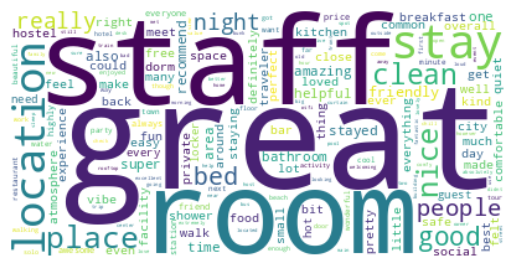

user_nationality_name: England


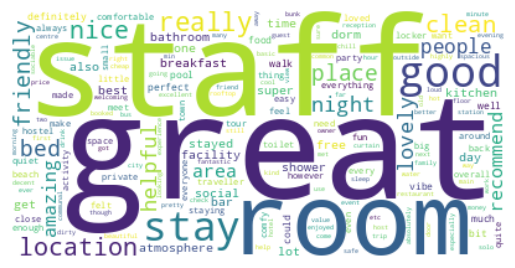

user_nationality_name: Canada


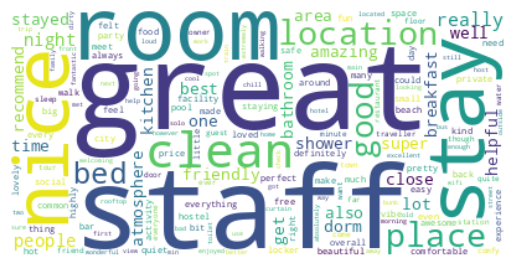

In [ ]:
# text description analysis & text representation
word_cloud_frequency(df = my_endf)
#the most frequently used words are same across three countries, which are "staff", "great" and "room"

user_gender_code: FEMALE


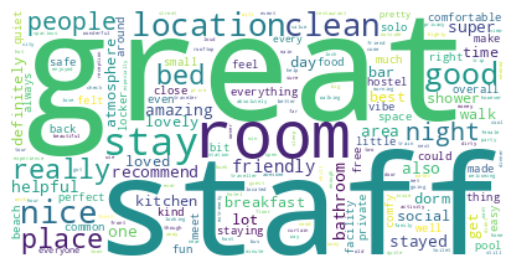

user_gender_code: MALE


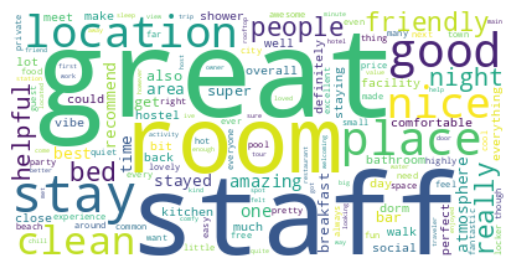

user_gender_code: COUPLE


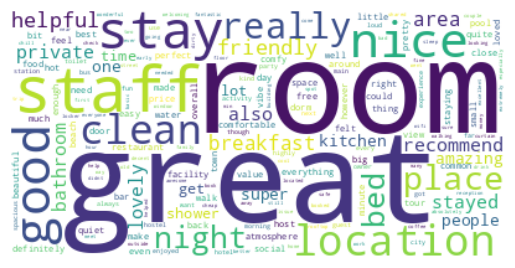

user_gender_code: MIXEDGROUP


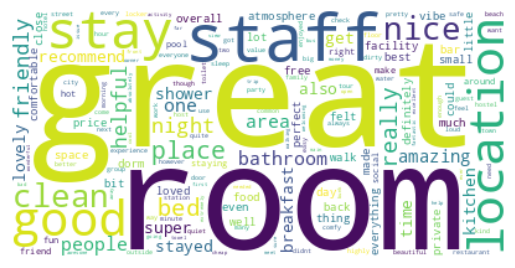

user_gender_code: ALLMALEGROUP


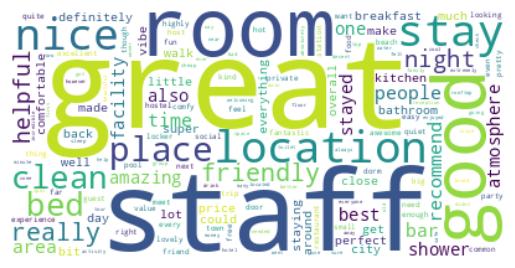

user_gender_code: ALLFEMALEGROUP


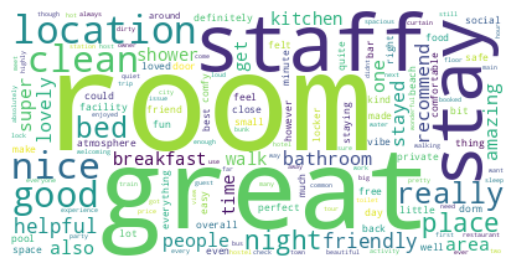

In [ ]:
word_cloud_frequency(df = my_endf, my_char='user_gender_code', my_text='clean_text')

In [ ]:
my_endf['type'].value_counts()

HOSTEL        310550
GUESTHOUSE      6761
HOTEL           6314
CAMPSITE         733
APARTMENT        516
Name: type, dtype: int64

type: HOTEL


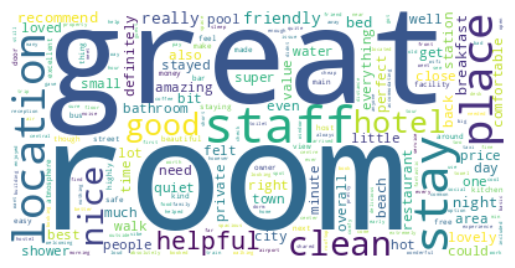

type: HOSTEL


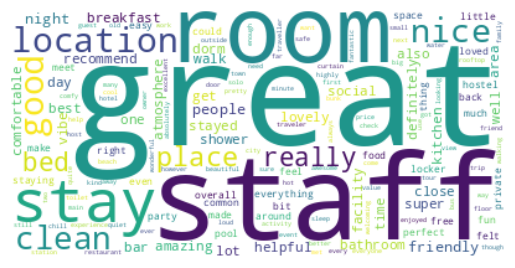

type: GUESTHOUSE


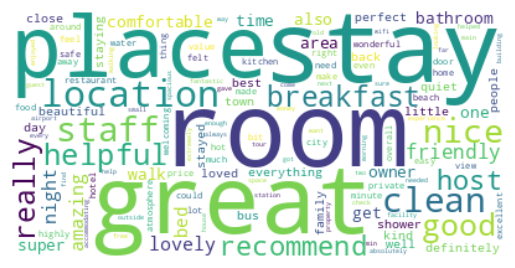

type: CAMPSITE


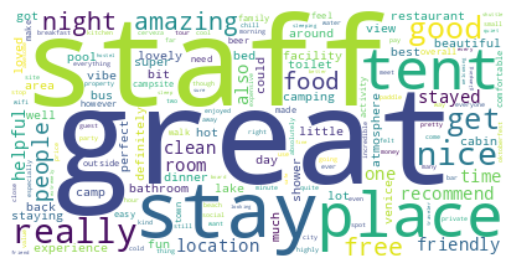

type: APARTMENT


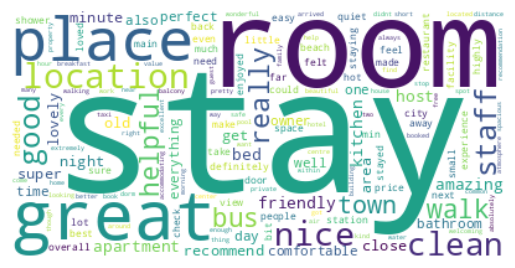

In [ ]:
word_cloud_frequency(df = my_endf, my_char='type', my_text='clean_text')

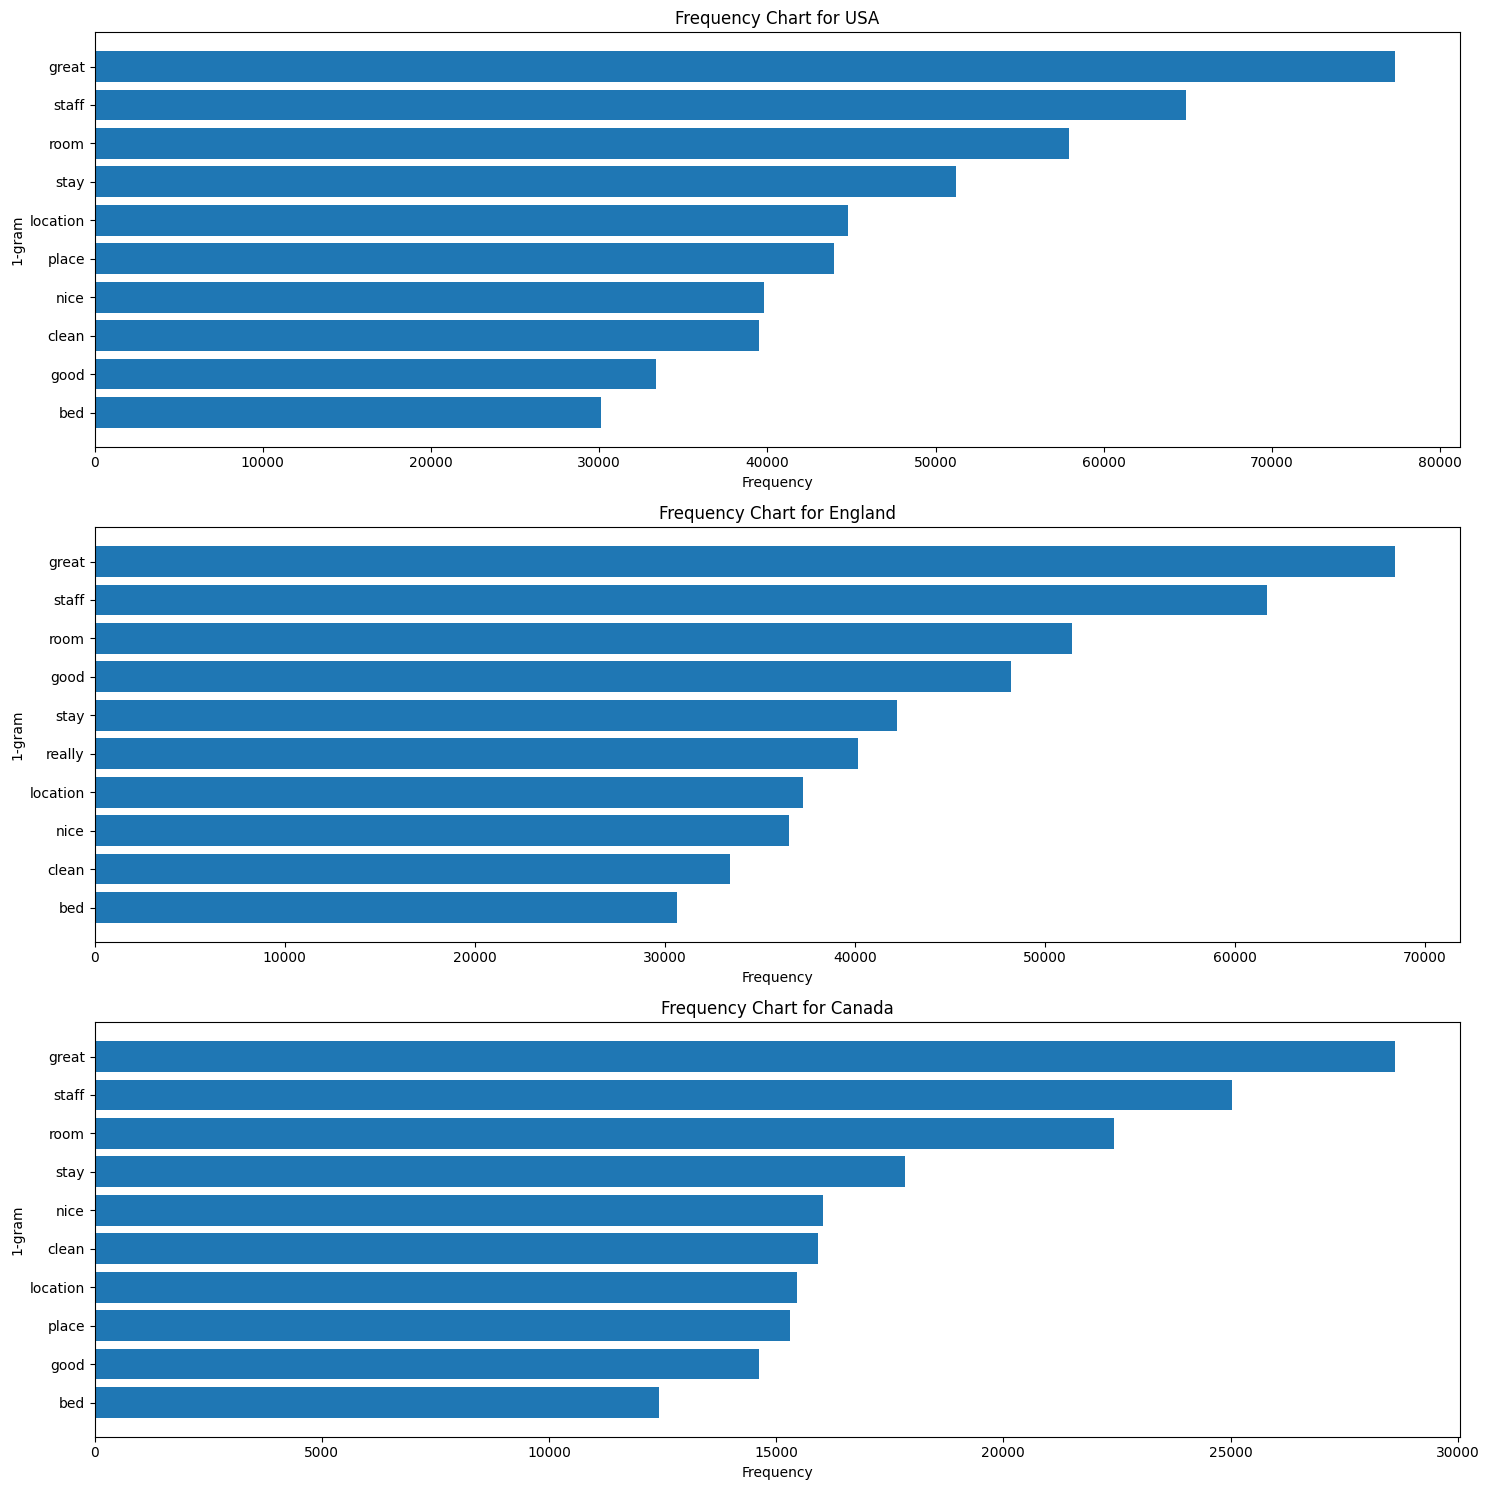

In [ ]:
#top=10, n = 1, num_columns = 2, my_char = 'user_nationality_name', my_text = 'clean_text'
fun_freqent_ngram(df = my_endf, n=1)

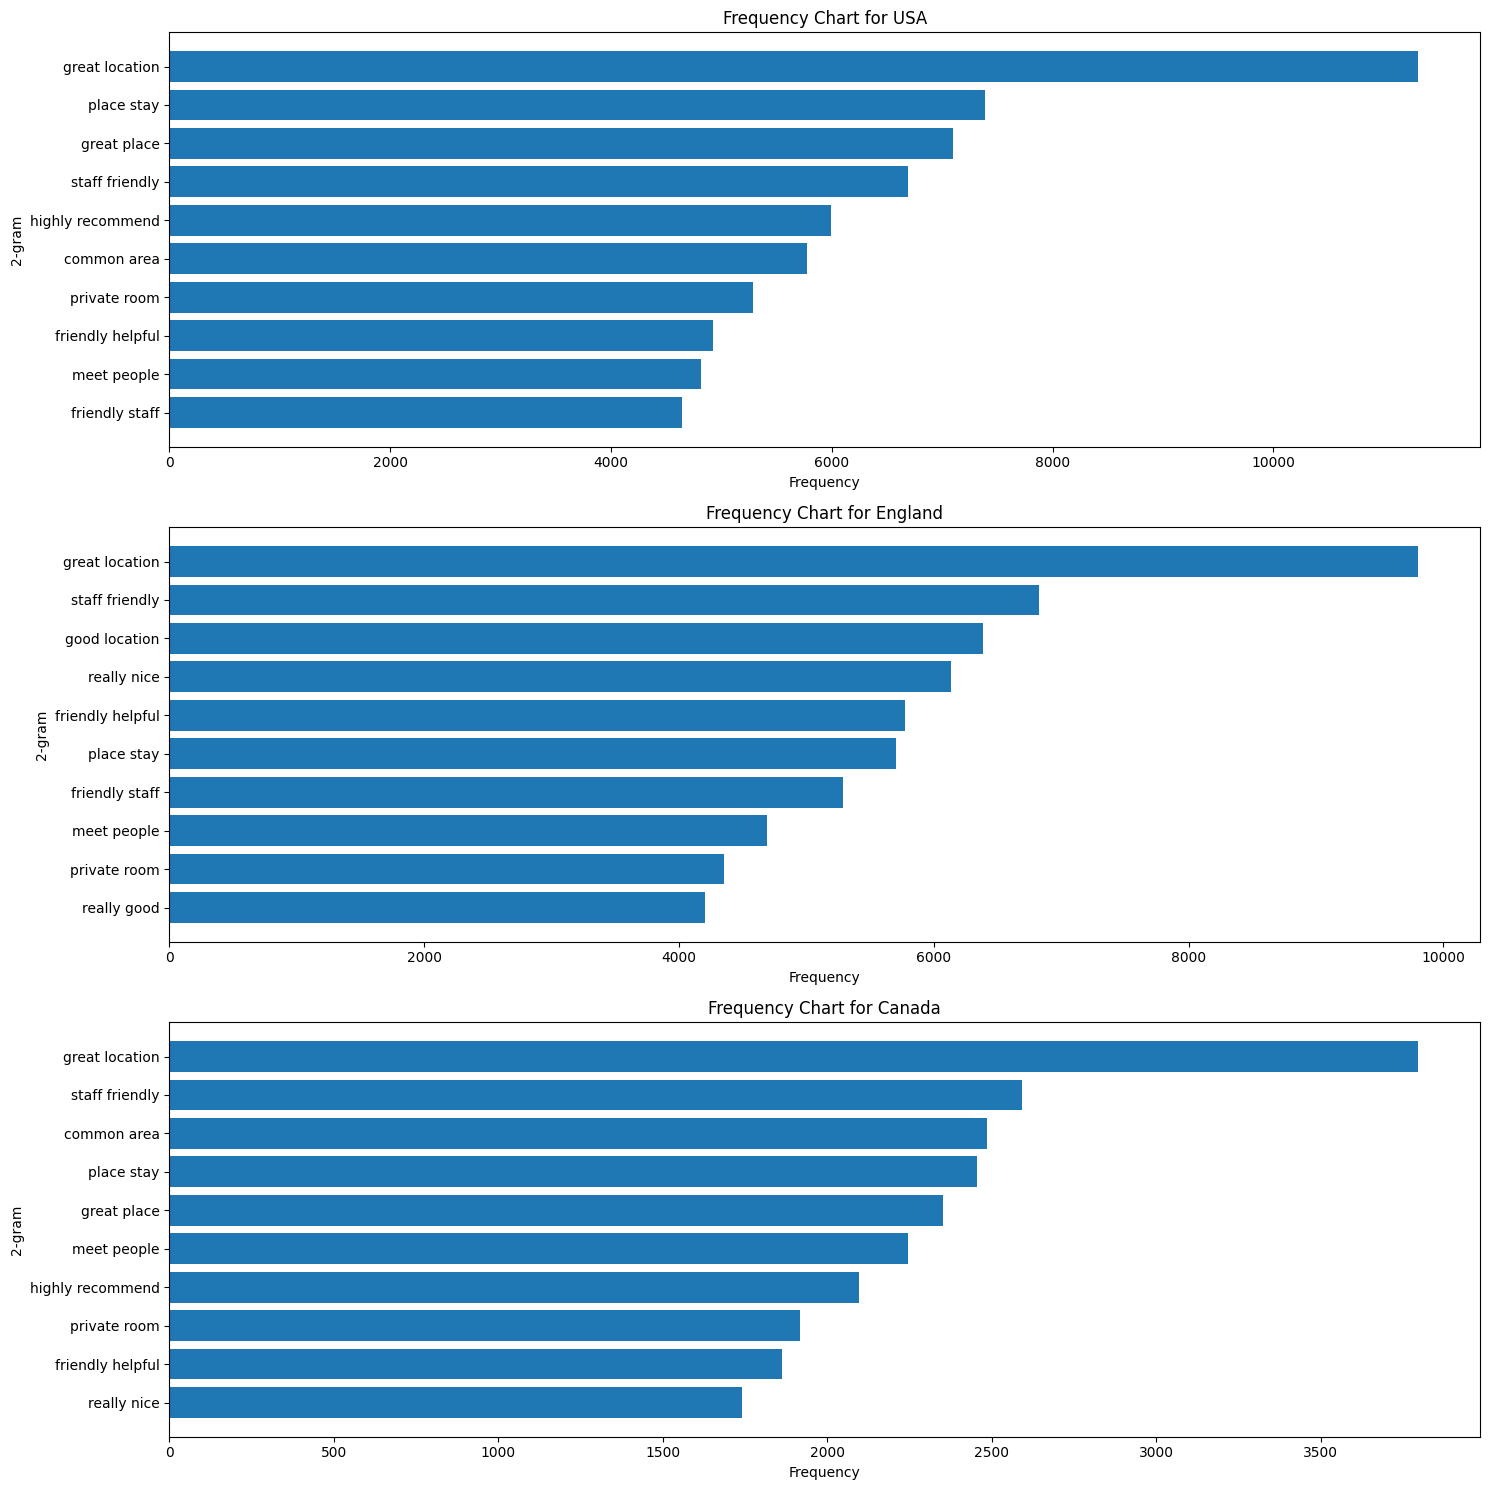

In [ ]:
#top=10, n = 2, num_columns = 2, my_char = 'user_nationality_name', my_text = 'clean_text'
fun_freqent_ngram(df = my_endf)

In [ ]:
print(my_endf.head(3))

   id_hostel                  name   type  totalRatings  starRating  city.name city.country                                             address review_date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name  user_number_reviews  review_safety_rate  review_location_rate  review_staff_rate  review_atmosphere_rate  review_cleanliness_rate  review_facilities_rate  review_rating_overall Language2                                                                                             

In [ ]:
# avg score
my_endf['avg_score'] = my_endf[['review_safety_rate',	'review_location_rate','review_staff_rate',	'review_atmosphere_rate',
                                'review_cleanliness_rate', 'review_facilities_rate']].mean(axis=1)

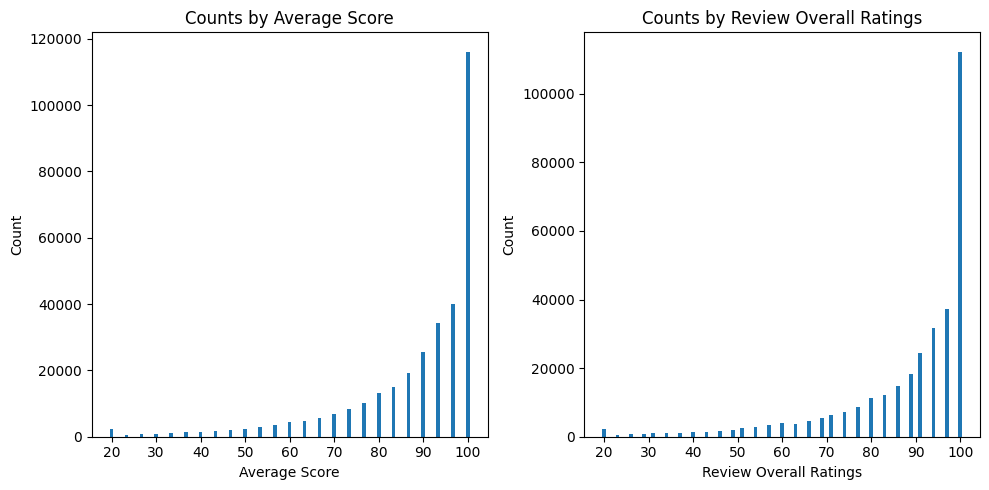

In [ ]:
#cross check calculated average score and the overall rating score
grouped_counts = my_endf.groupby(['avg_score','review_rating_overall']).size().reset_index(name='Count')

# Group by 'avg_score' and get counts
avg_score_counts = my_endf['avg_score'].value_counts().reset_index().rename(columns={'index': 'avg_score', 'avg_score': 'count'})

# Group by 'overall_ratings' and get counts
overall_ratings_counts = my_endf['review_rating_overall'].value_counts().reset_index().rename(columns={'index': 'overall_ratings', 'review_rating_overall': 'count'})

# Create charts for 'avg_score' and 'overall_ratings'
plt.figure(figsize=(10, 5))

# Chart for 'avg_score'
plt.subplot(1, 2, 1)
plt.bar(avg_score_counts['avg_score'], avg_score_counts['count'])
plt.xlabel('Average Score')
plt.ylabel('Count')
plt.title('Counts by Average Score')

# Chart for 'overall_ratings'
plt.subplot(1, 2, 2)
plt.bar(overall_ratings_counts['overall_ratings'], overall_ratings_counts['count'])
plt.xlabel('Review Overall Ratings')
plt.ylabel('Count')
plt.title('Counts by Review Overall Ratings')

plt.tight_layout()
plt.show()
#review overall rating and the average ratings have similar distributions, thus we'll use review rating overall directly
# It is clear that the ratings are skewed, 100 appeared the most

In [ ]:
print(grouped_counts.head())
#grouped_counts.to_csv(data_root + '/rating_counts.csv', index=False, sep=";")

   avg_score  review_rating_overall  Count
0  20.000000                     20   2325
1  20.000000                     23     30
2  20.000000                     26      9
3  20.000000                     31      3
4  23.333333                     23    381


In [ ]:
#check the description of review overall rating and assign positive & negative to the reviews
# positive = 1, negative = 0
print(my_endf['review_rating_overall'].describe())
#set threshold =94
threshold = 94
my_endf['sentiment_label'] = my_endf['review_rating_overall'].apply(lambda x: 1 if x >= threshold else 0)
print(my_endf['sentiment_label'].value_counts())

count    324874.000000
mean         88.153235
std          16.181910
min          20.000000
25%          83.000000
50%          94.000000
75%         100.000000
max         100.000000
Name: review_rating_overall, dtype: float64
1    181274
0    143600
Name: sentiment_label, dtype: int64


In [ ]:
print(my_endf.columns)
print(my_endf.shape)

Index(['id_hostel', 'name', 'type', 'totalRatings', 'starRating', 'city.name', 'city.country', 'address', 'review_date', 'review_comment', 'user_gender_code', 'user_age', 'user_trip_code', 'user_nationality_name', 'user_number_reviews', 'review_safety_rate', 'review_location_rate', 'review_staff_rate', 'review_atmosphere_rate', 'review_cleanliness_rate', 'review_facilities_rate', 'review_rating_overall', 'Language2', 'clean_text', 'avg_score', 'sentiment_label'], dtype='object')
(324874, 26)


In [ ]:
#select about 5000 samples from our data, as the dataset is too large for model training
# all the models take over 4 hours and then crash
df_model = my_endf[['name', 'type', 'starRating', 'city.name',	'city.country',	'address',	'review_date',	'review_comment',
                    'user_gender_code',	'user_age',	'user_trip_code',	'user_nationality_name','avg_score',
                    'review_rating_overall', 'sentiment_label', 'Language2', 'clean_text']]
df_model['combined_label'] = df_model['sentiment_label'].astype(str) + '_' + df_model['type'].astype(str) +'_' + df_model['user_nationality_name'].astype(str) + '_' + df_model['user_gender_code'].astype(str) +'_' + df_model['user_age'].astype(str) + '_' + df_model['user_trip_code'].astype(str)

#define total sample size desired
N = 5150
#perform stratified random sampling, random_state =10
df_model = df_model.groupby('combined_label', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df_model))),random_state=10)).sample(frac=1).reset_index(drop=True)

print(df_model.shape)
print(df_model['review_date'].agg(['min', 'max']))

(5004, 18)
min   2021-02-04
max   2024-02-05
Name: review_date, dtype: datetime64[ns]


In [ ]:
print(df_model.head(3))
print(type(df_model))

               name    type  starRating            city.name city.country address review_date                                                                                                                                                                                                                                                                                                                                                                                                                                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name   avg_score  review_rating_overall  sentiment_label Language2                                                                                                                                                                                                                                                                                                                                         

In [8]:
#save seleted sample to drive for future use
# dt.Frame(df_model).to_csv(data_root + '/Reviews_selectedv1.csv')
pd.set_option('display.max_colwidth', None)
df_model = dt.fread(data_root + '/Reviews_selectedv1.csv')
df_model = df_model.to_pandas()
threshold = 94
df_model['sentiment_label'] = df_model['review_rating_overall'].apply(lambda x: 1 if x >= threshold else 0)
print(df_model['sentiment_label'].value_counts())

sentiment_label
1    2804
0    2200
Name: count, dtype: int64


In [ ]:
# check data before text encoding
#pd.set_option('display.max_colwidth', None)
print(df_model.columns)
print(df_model.user_age.value_counts())

Index(['name', 'type', 'starRating', 'city.name', 'city.country', 'address', 'review_date', 'review_comment', 'user_gender_code', 'user_age', 'user_trip_code', 'user_nationality_name', 'avg_score', 'review_rating_overall', 'sentiment_label', 'Language2', 'clean_text', 'combined_label'], dtype='object')
18-24    1994
25-30    1777
31-40     787
41+       446
Name: user_age, dtype: int64


In [9]:
#combine 3 dimensions for the stratifed sampling
def combine_columns(df):
    return f"{df['sentiment_label']}_{df['type']}_{df['user_nationality_name']}"

with ThreadPoolExecutor() as executor:
      df_model['combined_label'] = list(executor.map(combine_columns, df_model.to_dict('records')))

In [ ]:
print(df_model.head(3))

               name    type  starRating            city.name city.country address review_date                                                                                                                                                                                                                                                                                                                                                                                                                                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name   avg_score  review_rating_overall  sentiment_label Language2                                                                                                                                                                                                                                                                                                                                         

In [ ]:
#BOW
# my_endf = my_endf[['name', 'type', 'starRating', 'city.name',	'city.country',	'address',	'review_date',	'review_comment',
#                     'user_gender_code',	'user_age',	'user_trip_code',	'user_nationality_name','avg_score',
#                     'review_rating_overall', 'sentiment_label', 'Language2', 'clean_text','combined_label']]
# Initialize CountVectorizer with desired options
vectorizer = CountVectorizer(max_features = 1000)
bow_matrix = vectorizer.fit_transform(df_model['clean_text'])

# Convert the sparse matrix to a DataFrame
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the BOW DataFrame with the original DataFrame
df_bow = pd.concat([df_model, bow_df], axis=1)

# check
print(df_bow.shape)

(5004, 1018)


In [ ]:
print(df_bow.head(2))

               name    type  starRating            city.name city.country address review_date                                                                                                                                                                                                                                                                                                                                                                                                                                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name  avg_score  review_rating_overall  sentiment_label Language2                                                                                                                                                                                                                                                                                                                                          

In [ ]:
# Initialize TfidfVectorizer with desired options, consider the top 1000 features ordered by term frequency across the corpus.
vectorizer = TfidfVectorizer(max_features = 1000)

# Fit and transform the text column
tfidf_matrix = vectorizer.fit_transform(df_model['clean_text'])

# Convert the sparse matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the TF-IDF DataFrame with the original DataFrame
df_tfidf = pd.concat([df_model, tfidf_df], axis=1)
print(df_tfidf.shape)

(5004, 1018)


In [ ]:
print(df_tfidf.head(2))

               name    type  starRating            city.name city.country address review_date                                                                                                                                                                                                                                                                                                                                                                                                                                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name  avg_score  review_rating_overall  sentiment_label Language2                                                                                                                                                                                                                                                                                                                                          

In [ ]:
# Doc2Vec, consider contextual information and usually outperforms simple-averaging of Word2Vec vectors
# There are two implementations:
# Paragraph Vector - Distributed Memory (PV-DM),PV-DM is analogous to Word2Vec CBOW
# Paragraph Vector - Distributed Bag of Words (PV-DBOW), PV-DBOW is analogous to Word2Vec SG.
# Tokenize the text and create tagged documents
tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df_model['clean_text'])]

# Initialize Doc2Vec model
# dm ({1,0}, optional) – Defines the training algorithm.
# If dm=1, ‘distributed memory’ (PV-DM) is used. Otherwise, distributed bag of words (PV-DBOW) is employed.
# negative (int, optional) – If > 0, negative sampling will be used,
# the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used
model_d2v = Doc2Vec(vector_size= 50, dm = 0, window=2, min_count=1, epochs=40, negative = 5)

# Build vocabulary
model_d2v.build_vocab(tagged_data)

# model train
model_d2v.train(tagged_data, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

# define a Function
def infer_vector(text):
    tokens = text.split()
    vector = model_d2v.infer_vector(tokens)
    return vector

# get the vector
df_model['doc2vec_vector'] = df_model['clean_text'].apply(infer_vector)

# Convert to dataframe
doc2vec_matrix = np.vstack(df_model['doc2vec_vector'])
doc2vec_df = pd.DataFrame(doc2vec_matrix, columns=[f'doc2vec_{i}' for i in range(doc2vec_matrix.shape[1])])

# Concatenate the Doc2Vec DataFrame with the original DataFrame
df_doc2vec = pd.concat([df_model, doc2vec_df], axis=1)
df_doc2vec = df_doc2vec.drop(['doc2vec_vector'], axis=1)
# Display the shape
print(df_doc2vec.shape)

(5004, 68)


In [ ]:
#doc2vec, vector size = 100
tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df_model['clean_text'])]
model = Doc2Vec(vector_size= 100, dm = 0, window=2, min_count=1, epochs=40, negative = 5)
# Build vocabulary
model.build_vocab(tagged_data)
# model train
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# define a Function
def infer_vector(text):
    tokens = text.split()
    vector = model.infer_vector(tokens)
    return vector

# get the vector
my_doc2vec = df_model.copy()
my_doc2vec['doc2vec_vector'] = my_doc2vec['clean_text'].apply(infer_vector)

# Convert to dataframe
doc2vec_matrix = np.vstack(my_doc2vec['doc2vec_vector'])
doc2vec_df = pd.DataFrame(doc2vec_matrix, columns=[f'doc2vec_{i}' for i in range(doc2vec_matrix.shape[1])])

# Concatenate the Doc2Vec DataFrame with the original DataFrame
my_doc2vec = pd.concat([my_doc2vec, doc2vec_df], axis=1)
my_doc2vec = my_doc2vec.drop(['doc2vec_vector'], axis=1)
# Display the shape
print(my_doc2vec.shape)
#took 23s

(5004, 118)


In [ ]:
#my_doc2vec.to_csv(data_root + '/my_doc2vec.csv', index=False, sep=";")
# my_doc2vec = dt.fread(data_root + '/my_doc2vec.csv')
# my_doc2vec = my_doc2vec.to_pandas()
# #read the csv,the 1/0 was saved as True/False
# threshold = 94
# my_doc2vec['sentiment_label'] = my_doc2vec['review_rating_overall'].apply(lambda x: 1 if x >= threshold else 0)
#print(my_doc2vec.head(3))
print(my_doc2vec.shape)
print(my_doc2vec.sentiment_label.value_counts())

(5004, 118)
1    2804
0    2200
Name: sentiment_label, dtype: int64


In [ ]:
#save doc2vec data as doc2vec encoding takes about 30 m to complete
# df_doc2vec.to_csv(data_root + '/reviews_doc2vec.csv', index=False, sep=";")
# df_doc2vec = dt.fread(data_root + '/reviews_doc2vec.csv')
# df_doc2vec = df_doc2vec.to_pandas()
# #read the csv,the 1/0 was saved as True/False
# threshold = 94
# df_doc2vec['sentiment_label'] = df_doc2vec['review_rating_overall'].apply(lambda x: 1 if x >= threshold else 0)
print(df_doc2vec.head(3))
print(df_doc2vec.shape)
print(df_doc2vec.sentiment_label.value_counts())

               name    type  starRating            city.name city.country address review_date                                                                                                                                                                                                                                                                                                                                                                                                                                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name   avg_score  review_rating_overall  sentiment_label Language2                                                                                                                                                                                                                                                                                                                                         

In [ ]:
# classification, sentiment analysis - classify reviews into positive and negative
# stratified sampling, 75% as traing dataset and 25% as testing dataset
def stratified_sampling(df):
    # Combine columns to create unique labels
    # df['combined_label'] = df['sentiment_label'].astype(str) + '_' + df['type'].astype(str) + '_' + df['user_nationality_name'].astype(str)

    # Define total sample size desired
    N = np.rint(len(df) * 0.75)

    # Perform stratified random sampling, random_state=10
    df_train = df.groupby('combined_label', group_keys=False).apply(lambda x: x.sample(int(np.rint(N * len(x) / len(df))), random_state=10)).sample(frac=1)
    df_test = df[~df.index.isin(df_train.index)]

    # Drop the combined_label column from the final dataframes
    df_train = df_train.drop(columns=['combined_label'])
    df_test = df_test.drop(columns=['combined_label'])

    return df_train, df_test

In [ ]:
# split dataset, a test, take quite a while to run
# train_bowx, test_bowx, train_bowy, test_bowy = stratified_sampling(df_bow)
# train_tfidfx, test_tfidfx, train_tfidfy, test_tfidfy = stratified_sampling(df_tfidf)
# train_d2vx, test_d2vx, train_d2vy, test_d2vy = stratified_sampling(df_doc2vec)
train_bowx, test_bowx= stratified_sampling(df_bow)
train_tfidfx, test_tfidfx = stratified_sampling(df_tfidf)
train_d2vx, test_d2vx = stratified_sampling(df_doc2vec) #vector size = 50
train_D2Vx, test_D2Vx = stratified_sampling(my_doc2vec) #vector size = 100
print('----------check splitting data, BOW---------------')
print(train_bowx.shape)
print(test_bowx.shape)

print('----------check splitting data, TFIDF---------------')
print(train_tfidfx.shape)
print(test_tfidfx.shape)

print('----------check splitting data, Doc2Vec, vector size = 50---------------')
print(train_d2vx.shape)
print(test_d2vx.shape)

print('----------check splitting data, Doc2Vec, vector size = 100---------------')
print(train_D2Vx.shape)
print(test_D2Vx.shape)

----------check splitting data, BOW---------------
(3753, 1017)
(1251, 1017)
----------check splitting data, TFIDF---------------
(3753, 1017)
(1251, 1017)
----------check splitting data, Doc2Vec, vector size = 50---------------
(3753, 67)
(1251, 67)
----------check splitting data, Doc2Vec, vector size = 100---------------
(3753, 117)
(1251, 117)


In [ ]:
print(train_d2vx.columns)
print(train_bowx.columns[0:24])

Index(['name', 'type', 'starRating', 'city.name', 'city.country', 'address', 'review_date', 'review_comment', 'user_gender_code', 'user_age', 'user_trip_code', 'user_nationality_name', 'avg_score', 'review_rating_overall', 'sentiment_label', 'Language2', 'clean_text', 'doc2vec_0', 'doc2vec_1', 'doc2vec_2', 'doc2vec_3', 'doc2vec_4', 'doc2vec_5', 'doc2vec_6', 'doc2vec_7', 'doc2vec_8', 'doc2vec_9', 'doc2vec_10', 'doc2vec_11', 'doc2vec_12', 'doc2vec_13', 'doc2vec_14', 'doc2vec_15', 'doc2vec_16', 'doc2vec_17', 'doc2vec_18', 'doc2vec_19', 'doc2vec_20', 'doc2vec_21', 'doc2vec_22', 'doc2vec_23', 'doc2vec_24', 'doc2vec_25', 'doc2vec_26', 'doc2vec_27', 'doc2vec_28', 'doc2vec_29', 'doc2vec_30', 'doc2vec_31', 'doc2vec_32', 'doc2vec_33', 'doc2vec_34', 'doc2vec_35', 'doc2vec_36', 'doc2vec_37', 'doc2vec_38', 'doc2vec_39', 'doc2vec_40', 'doc2vec_41', 'doc2vec_42', 'doc2vec_43', 'doc2vec_44', 'doc2vec_45', 'doc2vec_46', 'doc2vec_47', 'doc2vec_48', 'doc2vec_49'], dtype='object')
Index(['name', 'type', '

In [ ]:
test_d2vx['sentiment_label'].value_counts()

1    701
0    550
Name: sentiment_label, dtype: int64

In [144]:
#define a function to get the data for model training and testing
non_features = ['name', 'type', 'starRating', 'city.name', 'city.country', 'address', 'review_date',
                    'review_comment', 'user_gender_code', 'user_age', 'user_trip_code', 'user_nationality_name',
                    'avg_score', 'review_rating_overall', 'sentiment_label', 'Language2', 'clean_text']
target_label = ['sentiment_label']

def get_data_formodel(df_train, df_test):
  y_train = df_train[target_label]
  y_test = df_test[target_label]
  X_train = df_train.drop(non_features, axis=1)
  X_test = df_test.drop(non_features, axis=1)
  #min-max normalize the features as MultinomialNB does.t allow negative festures, mainly for Doc2Vec encoding
  scaler = MinMaxScaler()
  normalized_train = scaler.fit_transform(X_train)
  X_train = pd.DataFrame(normalized_train, columns=X_train.columns)
  normalized_test = scaler.fit_transform(X_test)
  X_test = pd.DataFrame(normalized_test, columns=X_test.columns)
  return X_train, X_test, y_train, y_test

In [145]:
#SVM, NB, RF and ensemble model
# Get data for training and testing
X_train, X_test, y_train, y_test = get_data_formodel(df_train=train_d2vx, df_test=test_d2vx)

# Define function to train and evaluate a model
def train_evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    return model_name, accuracy, y_proba, y_pred, cm, cr

# Define the models to train
models = [
    ('SVM', SVC(kernel='rbf', probability=True)),
    ('Naive Bayes', MultinomialNB()),
    ('Random Forest', RandomForestClassifier(n_estimators=200, random_state=10))
]

# Train and evaluate models in parallel using ProcessPoolExecutor
results = []
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(train_evaluate_model, model_name, model, X_train, X_test, y_train, y_test) for model_name, model in models]
    for future in futures:
        model_name, accuracy, y_proba, y_pred, cm, cr = future.result()
        results.append((model_name, accuracy, y_proba, y_pred, cm, cr))

# model train finish, took 10s

In [146]:
# ensemble model - weighted avg of proba
model_accuracies = [accuracy for _, accuracy, _, _, _, _ in results]
total_accuracy = sum(model_accuracies)
weights = [accuracy / total_accuracy for accuracy in model_accuracies]

# Extract Proba from results
arrays = [element[2] for element in results]
# Create a DataFrame from the arrays
prob_df = pd.DataFrame(arrays).T
prob_df.columns = [element[0] for element in results]

#ensmeble the proba
ensemble_column = prob_df.apply(lambda row: np.dot(row, weights), axis=1)
prob_df['ensemble_probs']  = ensemble_column

# Label the ensemble results as 0 or 1,
ensemble_predictions = (prob_df['ensemble_probs'] >= 0.5).astype(int)
# use voting to get another ensemble label
# Extract label from results
arrays = [element[3] for element in results]
# Create a DataFrame from the arrays
label_df = pd.DataFrame(arrays).T
label_df.columns = [element[0] for element in results]
def majority_vote(row):
    ones_count = row.sum()
    if ones_count >= 2:
        return 1
    else:
        return 0
label_df['ensemble_label']  = label_df.apply(majority_vote, axis=1)

print(prob_df.head(3))
print(label_df.head(3))
print('Ensmeble with Weighted Proba\n')
print(accuracy_score(y_test, ensemble_predictions))
print('Ensmeble with Voting\n')
print(accuracy_score(y_test, label_df['ensemble_label']))
#weighted avg method resulted in marginally higher accuracy

        SVM  Naive Bayes  Random Forest  ensemble_probs
0  0.667474     0.566767          0.655        0.635800
1  0.709971     0.572297          0.685        0.663829
2  0.490672     0.532060          0.435        0.481874
   SVM  Naive Bayes  Random Forest  ensemble_label
0    1            1              1               1
1    1            1              1               1
2    0            1              0               0
Ensmeble with Weighted Proba

0.7697841726618705
Ensmeble with Voting

0.7482014388489209


SVM, Naive Bayes, Random Forest models and Ensemble Model on Doc2Vec (vector size = 50) text representing

SVM - Accuracy: 0.76
SVM - Confusion Matrix:
[[389 161]
 [140 561]]



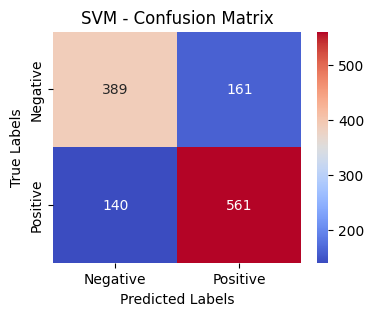

SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       550
           1       0.78      0.80      0.79       701

    accuracy                           0.76      1251
   macro avg       0.76      0.75      0.75      1251
weighted avg       0.76      0.76      0.76      1251


Naive Bayes - Accuracy: 0.56
Naive Bayes - Confusion Matrix:
[[  3 547]
 [  0 701]]



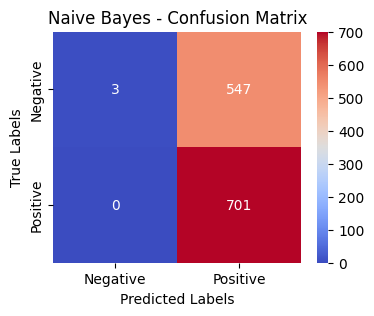

Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       550
           1       0.56      1.00      0.72       701

    accuracy                           0.56      1251
   macro avg       0.78      0.50      0.37      1251
weighted avg       0.75      0.56      0.41      1251


Random Forest - Accuracy: 0.76
Random Forest - Confusion Matrix:
[[359 191]
 [114 587]]



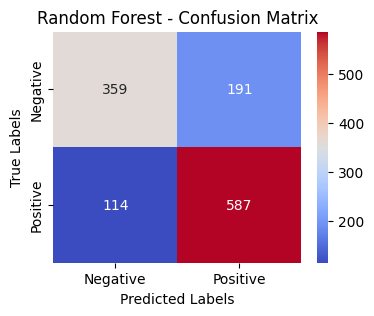

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       550
           1       0.75      0.84      0.79       701

    accuracy                           0.76      1251
   macro avg       0.76      0.75      0.75      1251
weighted avg       0.76      0.76      0.75      1251


Ensemble Model - Accuracy: 0.76
Ensemble Model - Confusion Matrix:
[[358 192]
 [102 599]]



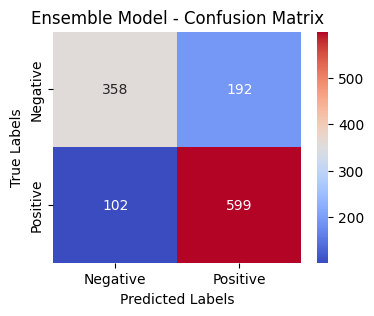

Ensemble Model - Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       550
           1       0.76      0.85      0.80       701

    accuracy                           0.76      1251
   macro avg       0.77      0.75      0.76      1251
weighted avg       0.77      0.76      0.76      1251




In [ ]:
# visulization
# emsemble model evaluation
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_cm = confusion_matrix(y_test, ensemble_predictions)
ensemble_cr = classification_report(y_test, ensemble_predictions)

# visulize confusion matrix
def cm_show(my_cm, model_name):
  plt.figure(figsize=(4, 3))
  sns.heatmap(my_cm, annot=True, cmap='coolwarm', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'{model_name} - Confusion Matrix')
  plt.show()
# Print individual model results
print('SVM, Naive Bayes, Random Forest models and Ensemble Model on Doc2Vec (vector size = 50) text representing\n')
for model_name, accuracy,_ ,y_pred, cm, cr in results:
    print(f'{model_name} - Accuracy: {accuracy:.2f}')
    print(f'{model_name} - Confusion Matrix:\n{cm}\n')
    # Plot confusion matrix
    cm_show(cm, model_name)
    print(f'{model_name} - Classification Report:\n{cr}\n')

# Print ensemble results
print(f'Ensemble Model - Accuracy: {ensemble_accuracy:.2f}')
print(f'Ensemble Model - Confusion Matrix:\n{ensemble_cm}\n')
cm_show(my_cm = ensemble_cm, model_name ='Ensemble Model')
print(f'Ensemble Model - Classification Report:\n{ensemble_cr}\n')
#ensemble the models didn't result in better results

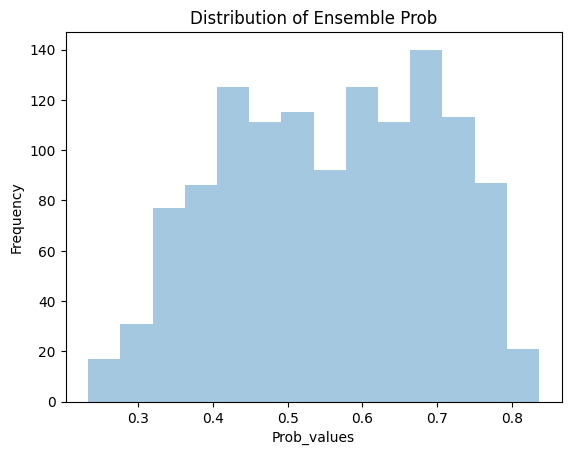

In [ ]:
#check the distribution of prob_df['ensemble_probs'], Set kde=False to show histogram only
sns.distplot(prob_df['ensemble_probs'], kde=False)
plt.xlabel('Prob_values')
plt.ylabel('Frequency')
plt.title('Distribution of Ensemble Prob')
plt.show()

In [ ]:
# same doc2vec, with vector size =100
X_train, X_test, y_train, y_test = get_data_formodel(df_train = train_D2Vx, df_test = test_D2Vx)

# Define function to train and evaluate a model
def train_evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    return model_name, accuracy, y_proba, y_pred, cm, cr

# Define the models to train
models = [
    ('SVM', SVC(kernel='rbf', probability=True)),
    ('Naive Bayes', MultinomialNB()),
    ('Random Forest', RandomForestClassifier(n_estimators=200, random_state=10))
]

# Train and evaluate models in parallel using ProcessPoolExecutor
results = []
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(train_evaluate_model, model_name, model, X_train, X_test, y_train, y_test) for model_name, model in models]
    for future in futures:
        model_name, accuracy, y_proba, y_pred, cm, cr = future.result()
        results.append((model_name, accuracy, y_proba, y_pred, cm, cr))

#took 21s

SVM, Naive Bayes, Random Forest models and Ensemble Model on Doc2Vec (vector size = 100) text representing

SVM - Accuracy: 0.77
SVM - Confusion Matrix:
[[354 196]
 [ 91 610]]



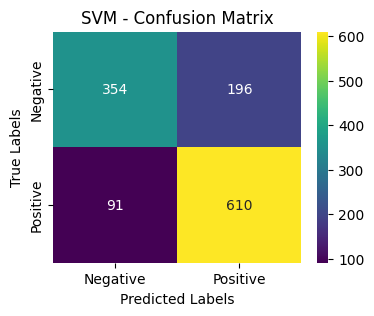

SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       550
           1       0.76      0.87      0.81       701

    accuracy                           0.77      1251
   macro avg       0.78      0.76      0.76      1251
weighted avg       0.77      0.77      0.77      1251


Naive Bayes - Accuracy: 0.60
Naive Bayes - Confusion Matrix:
[[ 56 494]
 [  2 699]]



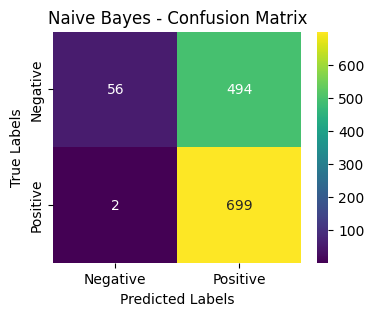

Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.10      0.18       550
           1       0.59      1.00      0.74       701

    accuracy                           0.60      1251
   macro avg       0.78      0.55      0.46      1251
weighted avg       0.75      0.60      0.49      1251


Random Forest - Accuracy: 0.76
Random Forest - Confusion Matrix:
[[402 148]
 [146 555]]



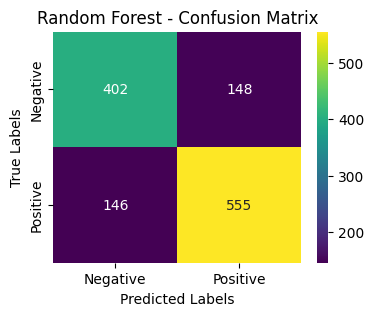

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       550
           1       0.79      0.79      0.79       701

    accuracy                           0.76      1251
   macro avg       0.76      0.76      0.76      1251
weighted avg       0.76      0.76      0.76      1251


Ensemble Model - Accuracy: 0.78
Ensemble Model - Confusion Matrix:
[[351 199]
 [ 79 622]]



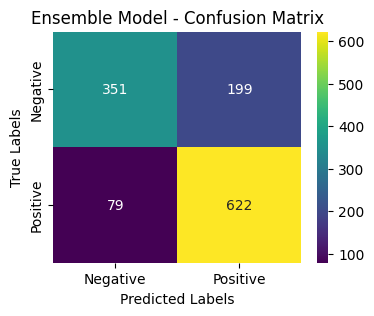

Ensemble Model - Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       550
           1       0.76      0.89      0.82       701

    accuracy                           0.78      1251
   macro avg       0.79      0.76      0.77      1251
weighted avg       0.78      0.78      0.77      1251




In [ ]:
# ensemble model - weighted avg of proba
model_accuracies = [accuracy for _, accuracy, _, _, _, _ in results]
total_accuracy = sum(model_accuracies)
weights = [accuracy / total_accuracy for accuracy in model_accuracies]

# Extract Proba from results
arrays = [element[2] for element in results]
# Create a DataFrame from the arrays
prob_df = pd.DataFrame(arrays).T
prob_df.columns = [element[0] for element in results]

#ensmeble the proba
ensemble_column = prob_df.apply(lambda row: np.dot(row, weights), axis=1)
prob_df['ensemble_probs']  = ensemble_column

# Label the ensemble results as 0 or 1,
ensemble_predictions = (prob_df['ensemble_probs'] >= 0.5).astype(int)

# visulization
# emsemble model evaluation
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_cm = confusion_matrix(y_test, ensemble_predictions)
ensemble_cr = classification_report(y_test, ensemble_predictions)

# visulize confusion matrix
def cm_show(my_cm, model_name):
  plt.figure(figsize=(4, 3))
  sns.heatmap(my_cm, annot=True, cmap='viridis', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'{model_name} - Confusion Matrix')
  plt.show()
# Print individual model results
print('SVM, Naive Bayes, Random Forest models and Ensemble Model on Doc2Vec (vector size = 100) text representing\n')
for model_name, accuracy,_ ,y_pred, cm, cr in results:
    print(f'{model_name} - Accuracy: {accuracy:.2f}')
    print(f'{model_name} - Confusion Matrix:\n{cm}\n')
    # Plot confusion matrix
    cm_show(cm, model_name)
    print(f'{model_name} - Classification Report:\n{cr}\n')

# Print ensemble results
print(f'Ensemble Model - Accuracy: {ensemble_accuracy:.2f}')
print(f'Ensemble Model - Confusion Matrix:\n{ensemble_cm}\n')
cm_show(my_cm = ensemble_cm, model_name ='Ensemble Model')
print(f'Ensemble Model - Classification Report:\n{ensemble_cr}\n')
# increase the vector size to 100 didn't make the model accuracy higher, resulted in similar results as vector size =50
#ensemble the models result in marginally better results

SVM, Naive Bayes, Random Forest models and Ensemble Model on TFIDF text representing

SVM - Accuracy: 0.78
SVM - Confusion Matrix:
[[435 115]
 [166 535]]



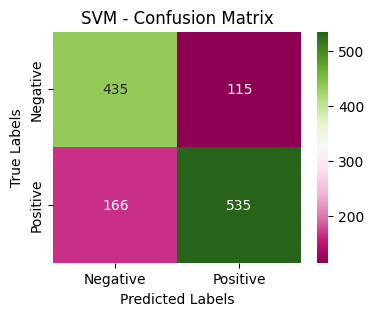

SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.76       550
           1       0.82      0.76      0.79       701

    accuracy                           0.78      1251
   macro avg       0.77      0.78      0.77      1251
weighted avg       0.78      0.78      0.78      1251


Naive Bayes - Accuracy: 0.79
Naive Bayes - Confusion Matrix:
[[392 158]
 [107 594]]



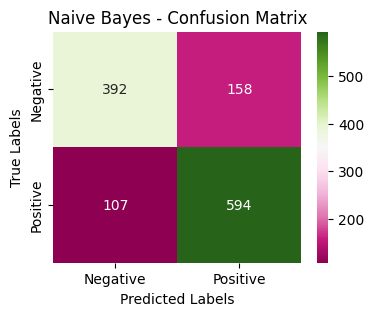

Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       550
           1       0.79      0.85      0.82       701

    accuracy                           0.79      1251
   macro avg       0.79      0.78      0.78      1251
weighted avg       0.79      0.79      0.79      1251


Random Forest - Accuracy: 0.77
Random Forest - Confusion Matrix:
[[364 186]
 [107 594]]



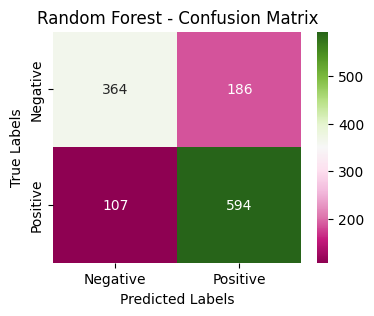

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       550
           1       0.76      0.85      0.80       701

    accuracy                           0.77      1251
   macro avg       0.77      0.75      0.76      1251
weighted avg       0.77      0.77      0.76      1251


Ensemble Model - Accuracy: 0.80
Ensemble Model - Confusion Matrix:
[[414 136]
 [120 581]]



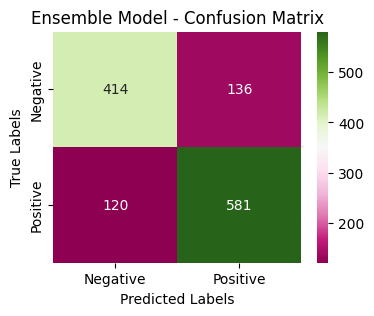

Ensemble Model - Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       550
           1       0.81      0.83      0.82       701

    accuracy                           0.80      1251
   macro avg       0.79      0.79      0.79      1251
weighted avg       0.79      0.80      0.80      1251




In [ ]:
# SVM, NB and random forest resulted in similar accuracy, SVM and NB had overall marginally higher accuracy
# SVM did better on classify positive reviews
# NB resulted in a more balanced results when looking into positive and negative ones
# similar model train on the TFIDF encoded data

X_train, X_test, y_train, y_test = get_data_formodel(df_train = train_tfidfx, df_test = test_tfidfx)

# Define function to train and evaluate a model
def train_evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    return model_name, accuracy, y_proba, y_pred, cm, cr

# Define the models to train
models = [
    ('SVM', SVC(kernel='rbf', probability=True)),
    ('Naive Bayes', MultinomialNB()),
    ('Random Forest', RandomForestClassifier(n_estimators=200, random_state=10))
]

# Train and evaluate models in parallel using ProcessPoolExecutor
results = []
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(train_evaluate_model, model_name, model, X_train, X_test, y_train, y_test) for model_name, model in models]
    for future in futures:
        model_name, accuracy, y_proba, y_pred, cm, cr = future.result()
        results.append((model_name, accuracy, y_proba, y_pred, cm, cr))

model_accuracies = [accuracy for _, accuracy, _, _, _, _ in results]
total_accuracy = sum(model_accuracies)
weights = [accuracy / total_accuracy for accuracy in model_accuracies]

# Extract Proba from results
arrays = [element[2] for element in results]
# Create a DataFrame from the arrays
prob_df = pd.DataFrame(arrays).T
prob_df.columns = [element[0] for element in results]

#ensmeble the proba
ensemble_column = prob_df.apply(lambda row: np.dot(row, weights), axis=1)
prob_df['ensemble_probs']  = ensemble_column

# Label the ensemble results as 0 or 1,
ensemble_predictions = (prob_df['ensemble_probs'] >= 0.5).astype(int)

# visulization
# emsemble model evaluation
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_cm = confusion_matrix(y_test, ensemble_predictions)
ensemble_cr = classification_report(y_test, ensemble_predictions)

# visulize confusion matrix
def cm_show(my_cm, model_name):
  plt.figure(figsize=(4, 3))
  sns.heatmap(my_cm, annot=True, cmap='PiYG', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(f'{model_name} - Confusion Matrix')
  plt.show()
# Print individual model results
print('SVM, Naive Bayes, Random Forest models and Ensemble Model on TFIDF text representing\n')
for model_name, accuracy,_ ,y_pred, cm, cr in results:
    print(f'{model_name} - Accuracy: {accuracy:.2f}')
    print(f'{model_name} - Confusion Matrix:\n{cm}\n')
    # Plot confusion matrix
    cm_show(cm, model_name)
    print(f'{model_name} - Classification Report:\n{cr}\n')

# Print ensemble results
print(f'Ensemble Model - Accuracy: {ensemble_accuracy:.2f}')
print(f'Ensemble Model - Confusion Matrix:\n{ensemble_cm}\n')
cm_show(my_cm = ensemble_cm, model_name ='Ensemble Model')
print(f'Ensemble Model - Classification Report:\n{ensemble_cr}\n')

#runtime 1m 22s

In [ ]:
#df_model.shape
# to make models are comparable, stratified selection 25% from df_model
train_x, test_x= stratified_sampling(df_model)
print(train_x.shape)
print(test_x.shape)
print(test_x.sentiment_label.value_counts())

(3753, 18)
(1251, 18)
1    701
0    550
Name: sentiment_label, dtype: int64


In [ ]:
# DistilBERT base uncased finetuned SST-2, on test_d2vx
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
model = DistilBertForSequenceClassification.from_pretrained(model_name)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# pretrained model, let's split my_endf (25% of the data to compare with other models)
#train_dbx, test_dbx, train_dby, test_dby = stratified_sampling(my_endf)

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1)
    sentiment = 1 if predicted_class.item() == 1 else 0 # positive =1, negative is 0
    return sentiment

# Define the function to process a chunk of data
def process_chunk(chunk):
    chunk['sentiment_predict'] = chunk['review_comment'].apply(predict_sentiment)
    return chunk

if __name__ == '__main__':

    # Split the DataFrame into chunks for parallel processing
    num_chunks = 100  # each chunk has 100 record
    chunks = [test_x[i:i + len(test_x) // num_chunks] for i in range(0, len(test_x), len(test_x) // num_chunks)]

    # Create a ProcessPoolExecutor for parallel processing
    with ProcessPoolExecutor() as executor:
        # Process each chunk in parallel
        results = executor.map(process_chunk, chunks)

    # Concatenate the results back into a single DataFrame
    DistilBERT_result = pd.concat(results)
 #runtime:~ 3 m

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

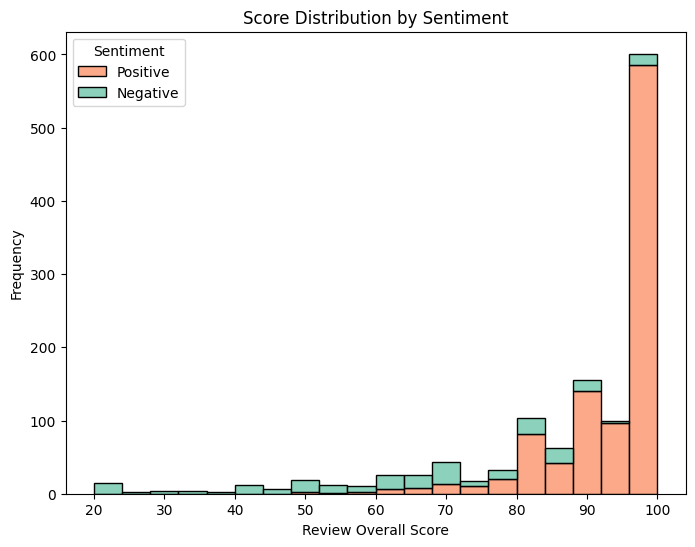

In [ ]:
#print(DistilBERT_result.head(3)), save model results
#DistilBERT_result.to_csv(data_root + '/DistilBERT_result.csv', index=False, sep=";")
# DistilBERT_result = dt.fread(data_root + '/DistilBERT_result.csv')
# DistilBERT_result = DistilBERT_result.to_pandas()
# Plot the score distribution by predict sentiment
plt.figure(figsize=(8, 6))
sns.histplot(data = DistilBERT_result, x='review_rating_overall', hue='sentiment_predict', bins=20, multiple='stack', palette='Set2')
plt.title('Score Distribution by Sentiment')
plt.xlabel('Review Overall Score')
plt.ylabel('Frequency')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'])
plt.show()

DistilBERT base uncased - Accuracy: 0.72
DistilBERT base uncased - Confusion Matrix:
[[223  20]
 [327 681]]



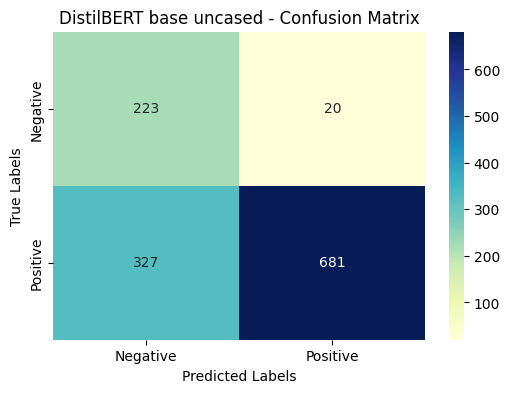

DistilBERT base uncased - Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.92      0.56       243
           1       0.97      0.68      0.80      1008

    accuracy                           0.72      1251
   macro avg       0.69      0.80      0.68      1251
weighted avg       0.86      0.72      0.75      1251




In [ ]:
#check model performance
accuracy = accuracy_score(DistilBERT_result['sentiment_predict'], DistilBERT_result['sentiment_label'])
cm = confusion_matrix(DistilBERT_result['sentiment_predict'], DistilBERT_result['sentiment_label'])
cr = classification_report(DistilBERT_result['sentiment_predict'], DistilBERT_result['sentiment_label'])
print(f'DistilBERT base uncased - Accuracy: {accuracy:.2f}')
print(f'DistilBERT base uncased - Confusion Matrix:\n{cm}\n')
# Plot confusion matrix
plt.figure(figsize=(6, 4))
#positive =1, negative = 0
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('DistilBERT base uncased - Confusion Matrix')
plt.show()
print(f'DistilBERT base uncased - Classification Report:\n{cr}\n')
#better at identify posiitve comments

In [ ]:
# leverage spacytextblob, has the shortest runtime within all the alogorithms we tried
# Load the spaCy English model and initialize SpacyTextBlob
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

# Function to perform sentiment analysis on a text using SpacyTextBlob
def analyze_sentiment(text):
    doc = nlp(text)
    polarity = doc._.polarity
    #return 1 if polarity > 0 else 0 # 1 for positive, 0 for negative
    # the threshold is selected based on the distribution of the polarity score
    my_sentiment = 1 if polarity > 0.25 else 0
    return my_sentiment, polarity

texts = test_x['clean_text'].tolist()

# Function to process each text and analyze sentiment
def process_text(text):
    return analyze_sentiment(text)

# Use ProcessPoolExecutor for parallel processing to save runtime
with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(analyze_sentiment, texts), total=len(texts)))

# Unpack the results into separate lists
my_sentiments, my_polarities = zip(*results)

# Assign sentiment results and polarity scores to the DataFrame
spacy_results = test_tfidfx.copy()
spacy_results['predict_sentiment'] = my_sentiments
spacy_results['polarity_score'] = my_polarities

100%|██████████| 1251/1251 [00:40<00:00, 31.22it/s]


Text(0.5, 0, 'Data')

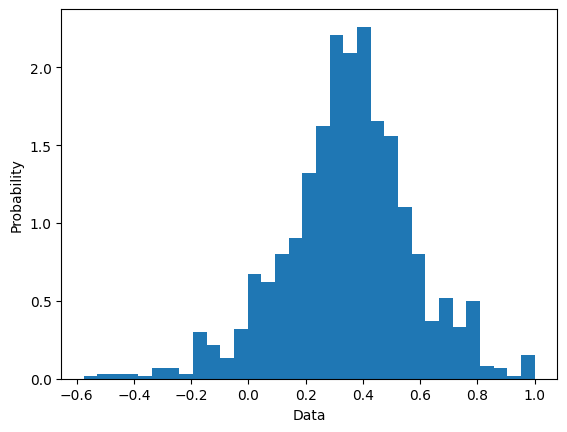

In [ ]:
# Concatenate the results back into a single DataFrame
#spacy_results[['predict_sentiment','sentiment_label','polarity_score']].head(3)
score = spacy_results['polarity_score'].to_numpy()
q25, q75 = np.percentile(score, [25, 75])
bin_width = 2 * (q75 - q25) * len(score) ** (-1/3)
bins = round((np.max(score) - np.min(score)) / bin_width)
plt.hist(score, density=True, bins=bins)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')

Spacy Textblob - Accuracy: 0.71
Spacy Textblob - Confusion Matrix:
[[277  84]
 [273 617]]



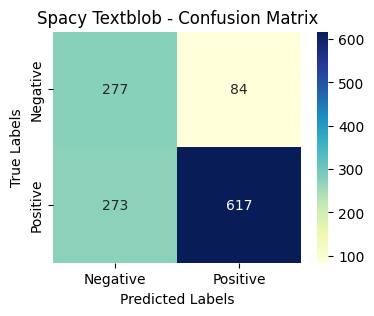

Spacy Textblob - Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.77      0.61       361
           1       0.88      0.69      0.78       890

    accuracy                           0.71      1251
   macro avg       0.69      0.73      0.69      1251
weighted avg       0.77      0.71      0.73      1251




In [ ]:
accuracy = accuracy_score(spacy_results['predict_sentiment'], spacy_results['sentiment_label'])
cm = confusion_matrix(spacy_results['predict_sentiment'], spacy_results['sentiment_label'])
cr = classification_report(spacy_results['predict_sentiment'], spacy_results['sentiment_label'])
print(f'Spacy Textblob - Accuracy: {accuracy:.2f}')
print(f'Spacy Textblob - Confusion Matrix:\n{cm}\n')
# Plot confusion matrix
plt.figure(figsize=(4, 3))
#positive =1, negative = 0
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Spacy Textblob - Confusion Matrix')
plt.show()
print(f'Spacy Textblob - Classification Report:\n{cr}\n')

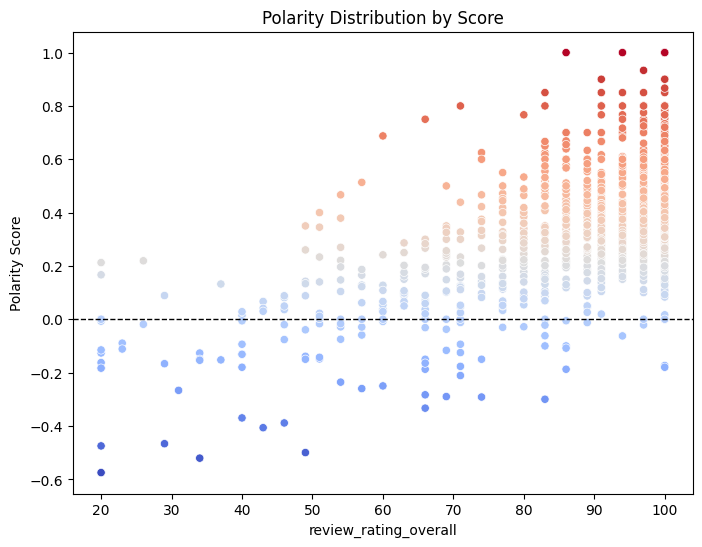

In [ ]:
#polarity vs. review overall rating
plt.figure(figsize=(8, 6))
sns.scatterplot(data= spacy_results, x='review_rating_overall', y='polarity_score', hue='polarity_score', palette='coolwarm', legend=None)
plt.title('Polarity Distribution by Score')
plt.xlabel('review_rating_overall')
plt.ylabel('Polarity Score')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at y=0 for reference
#plt.colorbar(label='polarity_score')
plt.show()
#we can see the polarity score and review scores were not seperated well

In [ ]:
# clustering (categories, such as location, service, cleaness...)
# Method1: Bertopic with PCA
docs = df_model['clean_text']
# mytopic_model = BERTopic(language="english", calculate_probabilities= False, top_n_words = 10,
#                          nr_topics = 15)
#bert_topics = mytopic_model.fit_transform(docs)
# nr_topics = 15
dim_model = PCA(n_components=5)
# mytopic_model = BERTopic( umap_model=dim_model).fit(docs)
mytopic_model = BERTopic(umap_model = dim_model)
topics, probs = mytopic_model.fit_transform(docs)
#run time = about

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#df_model.columns (can filter by location of hotel, age group, gender)
#save topic model, data_root + '/spacy_results.csv'
mytopic_model.save(data_root + '/BERTopic_basicv1')
# mytopic_model = BERTopic.load(data_root + '/BERTopic_basic')

2024-03-31 03:08:19,320 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
set(topics)
#type(mytopic_model.get_topic_info())

{-1, 0, 1}

In [ ]:
print(mytopic_model.get_topic_info())
# the mojority of the obs are in topic 0 (staff, room) and -1 (nassigned documents, didn't fit well in any topics)
# the Bertopic (one text clustering algorithm) didn't do well to identify the latent topic of each review
#while we can find the words that represent the topics, such as staff, room, location, clean, facility (such as pool, bed),
#food (such as breakfast)

   Topic  Count                          Name                                                          Representation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Representative_Docs
0     -1   1329  -1_great_staff_room_location   [great, staff, room, location, good, stay, clean, bed, nice, helpful]                                                                                                                                                     

In [ ]:
mytopic_model.visualize_barchart()

In [ ]:
print(df_model.head(2))

               name    type  starRating            city.name city.country address review_date                                                                                                                                                                                                                                                                                                                                                                                                                                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name  avg_score  review_rating_overall  sentiment_label Language2                                                                                                                                                                                                                                                                                                                                          

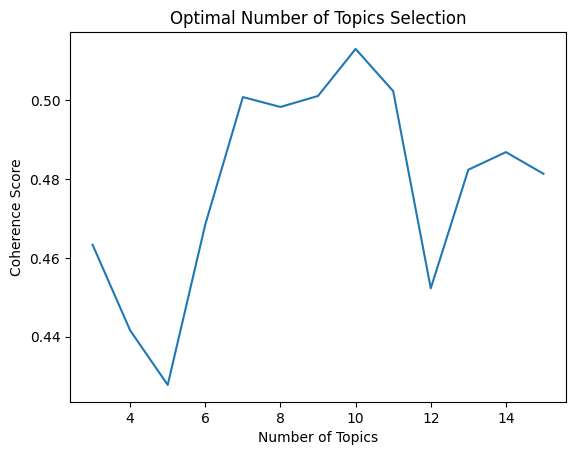

In [12]:
#LDA
tokenized_texts = [text.split() for text in df_model['clean_text']]
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Find optimal number of topics
start_topics = 3
end_topics = 15
step = 1

coherence_scores = []
for num_topics in range(start_topics, end_topics + 1, step):
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state = 100)
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Plot coherence scores to find optimal number of topics
plt.plot(range(start_topics, end_topics + 1, step), coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics Selection")
plt.show()

In [13]:
optimal_num_topics = start_topics + coherence_scores.index(max(coherence_scores))
print(f'Optimal Number of Topics: {optimal_num_topics}')

# Train LDA model with optimal number of topics
lda_model = LdaModel(corpus, num_topics=optimal_num_topics, id2word=dictionary, passes=15, random_state = 100)

# Visualize topics
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
#gensimvis.display(vis_data)
#pyLDAvis.display(vis_data)

# Get coherence score with the optimal model
coherence_model_optimal = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
coherence_score_optimal = coherence_model_optimal.get_coherence()
print(f'Optimal Coherence Score: {coherence_score_optimal:.4f}')


Optimal Number of Topics: 10
Optimal Coherence Score: 0.5130


In [14]:
vis_data
#didn't result in meaningful categories

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.205464 -0.065959       1        1  28.026129
8     -0.211908  0.046797       2        1  23.679609
6     -0.242692 -0.145237       3        1  21.441294
3     -0.079925  0.043160       4        1   7.373636
0     -0.064564  0.117575       5        1   7.140170
1      0.082624  0.222287       6        1   4.267315
2      0.046155 -0.016031       7        1   3.465197
7      0.218152 -0.062995       8        1   1.803600
9      0.220293 -0.082387       9        1   1.780713
4      0.237329 -0.057209      10        1   1.022337, topic_info=                  Term         Freq        Total Category  logprob  loglift
29             'room',  1881.000000  1881.000000  Default  30.0000  30.0000
13            'great',  1790.000000  1790.000000  Default  29.0000  29.0000
92           ['great',   605.000000   605.000000  Default  28.0000  28.0000
207             'bed',   995.000000   995.000000  Default  27.0000  27.0000
24            'night',   803.000000   803.000000  Default  26.0000  26.0000
43             'good',  1214.000000  1214.000000  Default  25.0000  25.0000
46         'location',  1331.000000  1331.000000  Default  24.0000  24.0000
533        'bathroom',   575.000000   575.000000  Default  23.0000  23.0000
991         'station',   185.000000   185.000000  Default  22.0000  22.0000
307           'train',   127.000000   127.000000  Default  21.0000  21.0000
180            'walk',   371.000000   371.000000  Default  20.0000  20.0000
77         'friendly',   852.000000   852.000000  Default  19.0000  19.0000
174          'locker',   242.000000   242.000000  Default  18.0000  18.0000
142            'nice',  1106.000000  1106.000000  Default  17.0000  17.0000
454           ['best',   113.000000   113.000000  Default  16.0000  16.0000
31           'shower',   443.000000   443.000000  Default  15.0000  15.0000
310            'felt',   299.000000   299.000000  Default  14.0000  14.0000
218            'make',   335.000000   335.000000  Default  13.0000  13.0000
248             'one',   598.000000   598.000000  Default  12.0000  12.0000
52            'staff',  2018.000000  2018.000000  Default  11.0000  11.0000
44          'helpful',   700.000000   700.000000  Default  10.0000  10.0000
5               'day',   412.000000   412.000000  Default   9.0000   9.0000
87             'time',   503.000000   503.000000  Default   8.0000   8.0000
584            'cool',   164.000000   164.000000  Default   7.0000   7.0000
206         'amazing',   528.000000   528.000000  Default   6.0000   6.0000
3             'clean',  1183.000000  1183.000000  Default   5.0000   5.0000
536           'close',   363.000000   363.000000  Default   4.0000   4.0000
54             'best',   404.000000   404.000000  Default   3.0000   3.0000
662            'ever',   205.000000   205.000000  Default   2.0000   2.0000
409            'need',   237.000000   237.000000  Default   1.0000   1.0000
592       'organized',    37.985117    38.745896   Topic1  -6.7420   1.2522
3223        'hangout',    31.014442    31.775331   Topic1  -6.9447   1.2478
2173       'welcomed',    29.289020    30.050381   Topic1  -7.0019   1.2464
952           'truly',    24.755599    25.516399   Topic1  -7.1701   1.2418
852          'return']    22.113381    22.889362   Topic1  -7.2830   1.2375
1626         'energy',    20.088671    20.849608   Topic1  -7.3790   1.2349
663             'ive',    94.155744    97.873822   Topic1  -5.8342   1.2333
1168         'fellow',    19.119036    19.879916   Topic1  -7.4285   1.2330
1172      'waterfall',    17.780578    18.541367   Topic1  -7.5010   1.2301
84         'shoutout',    17.773125    18.534974   Topic1  -7.5015   1.2301
903          'friend']    17.684840    18.445590   Topic1  -7.5064   1.2299
1815        'nightly',    18.131720    18.934291   Topic1  -7.4815   1.2287
595            'sure']    16.618626    17

In [ ]:
#define the words related with each category
vectors = { 'cleanliness': ["satisfactory", "ample", "hygienic", "proper", "ambience", "odour","dirty","clean","smell","cleanliness","spotless","unclean"],
'service':["desk", "check in", "check out", "reliable", "fast", "convenient","service","hospitality", "inconvenient"],
'location':["railway", "view","station","airport","distance","far","close","train", "metro","transport","market","mall","surrounding","areas","highway","traffic","out","location"],
'price':["price", "amount", "rate", "cheap", "worth", "low", 'money', "economical", "reasonable", "fee", "expensive", "charge","value","budget","bonus"],
'room':["bed","bunkbeds","toilet", "bathroom", "shower","dryer","fridge", "space", "spacious", "outdated", "noisy","room","bug","decoration","small"],
'food':["drink","breakfast","spicy", "food","tasty","tea","coffee", "buffet", "bar", "restaurant","dinner","lunch","brunch","delicious"],
'facility':["pool","gym","wifi","spa","internet","wireless","broken","parking","ventilation","maintained","facility","lot","premises","shower","kitchen"],
'staff':["friendly","helpful","reliable","quick","good","polite","staff","owner","courteous","kind","rude","disengaged"],
'atmosphere':["social", "atmosphere","party", "relaxing", "quiet","loverly", "chill","loverly","vibe"],
'safety':["safe", "danger", "risk", "violence", "security","unsafe","secure"]}
#calculate similarity
model = model_d2v

def encode_text(text):
    return model.infer_vector(text.split())

# Function to calculate text similarity
def calculate_text_similarity(text_vector, vector):
    vector_embedding = model.infer_vector(vector)
    cosine_sim = 1 - cosine(text_vector, vector_embedding)
    return cosine_sim

In [ ]:
def apply_text_similarity(row):
    text = row['clean_text']
    text_vector = encode_text(text)
    similarities = {}
    for vector_name, vector in vectors.items():
        similarities[f'{vector_name}_cosine_similarity'] = calculate_text_similarity(text_vector, vector)
    return pd.Series(similarities)

similarities_cos = df_model.apply(apply_text_similarity, axis=1)

In [ ]:
# print(similarities_cos.head())
def calculate_text_similarity(text_vector, vector):
    vector_embedding = model.infer_vector(vector)
    corr_sim = 1- correlation(text_vector, vector_embedding)
    return corr_sim

def apply_text_similarity(row):
    text = row['clean_text']
    text_vector = encode_text(text)
    similarities = {}
    for vector_name, vector in vectors.items():
        similarities[f'{vector_name}_corr_similarity'] = calculate_text_similarity(text_vector, vector)
    return pd.Series(similarities)

similarities_corr = df_model.apply(apply_text_similarity, axis=1)

In [ ]:
# print(similarities_corr.head(3))
def calculate_fuzzy_similarity(text, vector):
    corr_fuzz = fuzz.token_set_ratio(text, " ".join(vector))
    return corr_fuzz

def apply_text_similarity(row):
    text = row['clean_text']
    similarities = {}
    for vector_name, vector in vectors.items():
        similarities[f'{vector_name}_fuzzy_similarity'] = calculate_fuzzy_similarity(text, vector)
    return pd.Series(similarities)

similarities_fuzz = df_model.apply(apply_text_similarity, axis=1)

In [ ]:
# print(similarities_fuzz.head(3))
# standadize (minmax scaler) similarity dataframe then calculate the avg of the distance, then assign the label as the column name which has the maximum value
scaler = MinMaxScaler()

# Min-max normalize each dataframe
similarities_cos_normalized = pd.DataFrame(scaler.fit_transform(similarities_cos), columns= similarities_cos.columns)
similarities_corr_normalized = pd.DataFrame(scaler.fit_transform(similarities_corr), columns=similarities_corr.columns)
similarities_fuzz_normalized = pd.DataFrame(scaler.fit_transform(similarities_fuzz), columns=similarities_fuzz.columns)

# Calculate average across the normalized dataframes
average_df = pd.DataFrame(np.mean([similarities_cos_normalized.values, similarities_corr_normalized.values,
                                   similarities_fuzz_normalized.values], axis=0),
                          columns= ['cleanliness','service','location','price','room','food','facility','staff','atmosphere','safety'])

average_df['category_label'] = average_df.apply(lambda row: row.idxmax(), axis=1)

In [ ]:
print(similarities_cos_normalized.head(1))
print(similarities_corr_normalized.head(1))
print(similarities_fuzz_normalized.head(1))
print(average_df.head(1))

   cleanliness_cosine_similarity  service_cosine_similarity  location_cosine_similarity  price_cosine_similarity  room_cosine_similarity  food_cosine_similarity  facility_cosine_similarity  staff_cosine_similarity  atmosphere_cosine_similarity  safety_cosine_similarity
0                       0.761711                    0.83745                    0.476755                  0.35125                0.456541                0.494632                     0.67867                 0.472008                       0.42423                  0.648771
   cleanliness_corr_similarity  service_corr_similarity  location_corr_similarity  price_corr_similarity  room_corr_similarity  food_corr_similarity  facility_corr_similarity  staff_corr_similarity  atmosphere_corr_similarity  safety_corr_similarity
0                     0.724394                 0.820642                  0.454743               0.392506              0.442473              0.462803                  0.715948               0.476044             

In [ ]:
# sentiment label, method - use distilbert-base-uncased-finetuned-sst-2-english, this model has a decent accuracy score
# plus, the overall review score and review comments are not always expressing same emotions
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
model = DistilBertForSequenceClassification.from_pretrained(model_name)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# pretrained model

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1)
    sentiment = 1 if predicted_class.item() == 1 else 0 # positive =1, negative is 0
    return sentiment

# Define the function to process a chunk of data
def process_chunk(chunk):
    chunk['sentiment_predict'] = chunk['review_comment'].apply(predict_sentiment)
    return chunk

if __name__ == '__main__':

    # Split the DataFrame into chunks for parallel processing
    num_chunks = 100  # each chunk has 100 record
    chunks = [df_model[i:i + len(df_model) // num_chunks] for i in range(0, len(df_model), len(df_model) // num_chunks)]

    # Create a ProcessPoolExecutor for parallel processing
    with ProcessPoolExecutor() as executor:
        # Process each chunk in parallel
        results = executor.map(process_chunk, chunks)

    # Concatenate the results back into a single DataFrame
    DistilBERT_result = pd.concat(results)

In [ ]:
# check model results
print(DistilBERT_result.head(2))
print(DistilBERT_result.sentiment_predict.value_counts())

               name    type  starRating            city.name city.country address review_date                                                                                                                                                                                                                                                                                                                                                                                                                                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name  avg_score  review_rating_overall  sentiment_label Language2                                                                                                                                                                                                                                                                                                                                          

In [ ]:
# concat dataset to get category and sentiment
my_final_df = pd.concat([ DistilBERT_result, average_df], axis=1)
print(my_final_df.head(2))
# sentiment_predict and category_label are predicted sentiment and classsfied category for chatbot

               name    type  starRating            city.name city.country address review_date                                                                                                                                                                                                                                                                                                                                                                                                                                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name  avg_score  review_rating_overall  sentiment_label Language2                                                                                                                                                                                                                                                                                                                                          

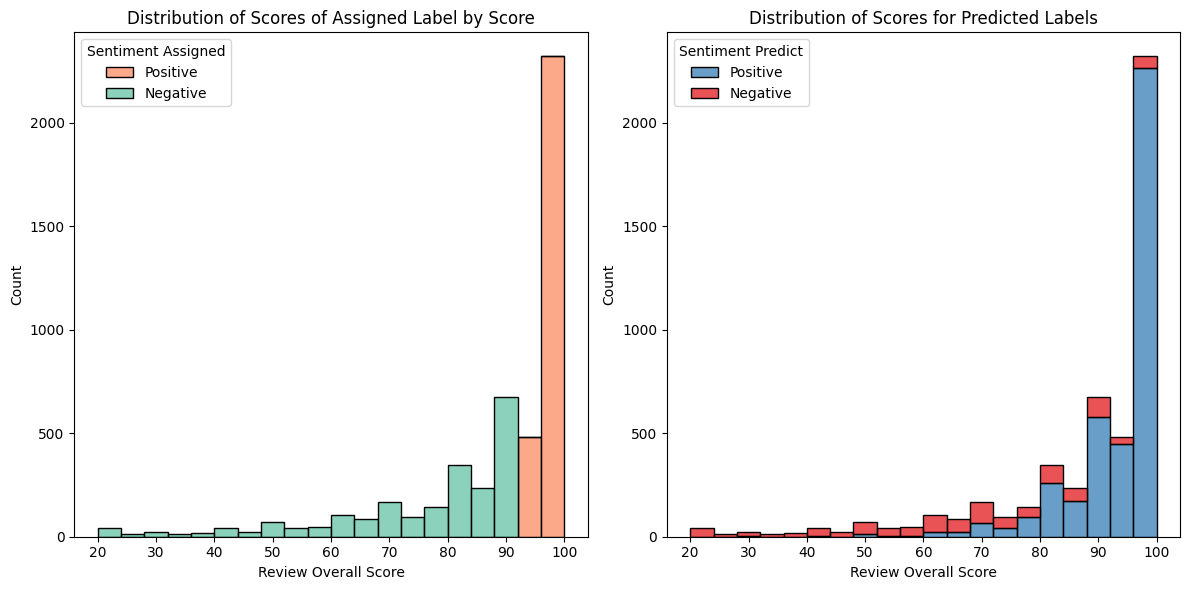

In [115]:
#error analysis
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(my_final_df, x='review_rating_overall', hue='sentiment_label', bins=20, multiple='stack', palette='Set2', ax=axs[0])
axs[0].set_title('Distribution of Scores of Assigned Label by Score')
axs[0].set_xlabel('Review Overall Score')
axs[0].set_ylabel('Count')
axs[0].legend(title='Sentiment Assigned', labels=['Positive', 'Negative'])

sns.histplot(my_final_df, x='review_rating_overall', hue='sentiment_predict', bins=20, multiple='stack', palette='Set1', ax=axs[1])
axs[1].set_title('Distribution of Scores for Predicted Labels')
axs[1].set_xlabel('Review Overall Score')
axs[1].set_ylabel('Count')
axs[1].legend(title='Sentiment Predict', labels=['Positive', 'Negative'])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [117]:
#check predicted as negative label, but has overall score >= 94
check_set1 = my_final_df.loc[(my_final_df['review_rating_overall'] >= 94) & (my_final_df['sentiment_predict'] == 0)]
print(check_set1.shape)
print(check_set1[['review_comment','review_rating_overall','sentiment_label', 'sentiment_predict']].head())
#these comments were classified as negative as: some negative things are mentioned in the comments

(93, 31)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      review_comment  review_rating_overall  sentiment_label  sentiment_predict
5                                                                                                                                                                                                                                                                                                                                                                                     Had a great time here. Easy to meet new people and centrally located. Wis

In [135]:
def fun_freqent_ngram(df, top=10, n=2, num_columns=1, my_text='clean_text'):
    char_texts = df[my_text].astype(str).str.cat(sep=' ')
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngrams_matrix = vectorizer.fit_transform([char_texts])  # Pass a list of texts to fit_transform
    ngrams_list = vectorizer.get_feature_names_out()
    # Sum up n-gram occurrences
    ngrams_count = ngrams_matrix.sum(axis=0)
    ngrams_counter = Counter(dict(zip(ngrams_list, ngrams_count.A1)))
    sorted_ngrams = dict(sorted(ngrams_counter.items(), key=lambda x: x[1], reverse=True))
    # Plot frequency chart for the top n-grams
    plt.barh(*zip(*list(sorted_ngrams.items())[:top][::-1]), color = 'deepskyblue')
    plt.xlabel('N-grams')
    plt.ylabel('Frequency')
    plt.title(f'Top {top} {n}-grams Frequency Chart')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

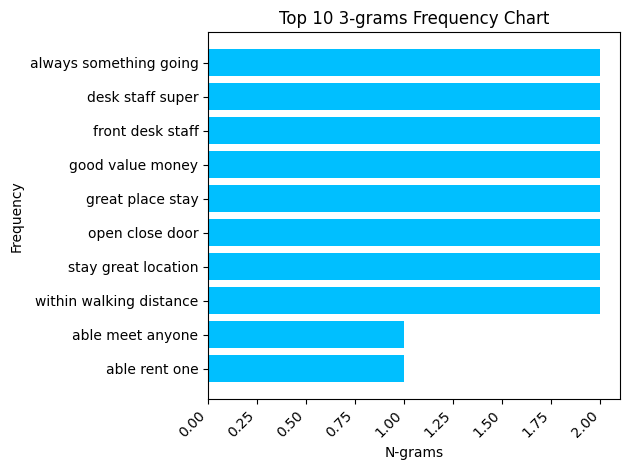

In [136]:
#check freqnuently mentioned words in check_set1
# fun_freqent_ngram(df=check_set1, top=10, n=3, num_columns=1, my_char='user_nationality_name', my_text='clean_text')
fun_freqent_ngram(df=check_set1, top=10, n=3, num_columns=1, my_text='clean_text')
# we can see that the top10 frequently used words in this dataset are positive

In [121]:
check_set2 = my_final_df.loc[(my_final_df['review_rating_overall'] < 94) & (my_final_df['sentiment_predict'] == 1)]
print(check_set2.shape)
print(check_set2[['review_comment','review_rating_overall','sentiment_label', 'sentiment_predict']].head())

(1283, 31)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                             review_comment  review_rating_overall  sentiment_label  sentiment_predict
1                                                                                                                                                                                                                                                                                                            Perfect place for a couple days of rest, a good location, and extremely helpful staff. Limited facilities and not much of a social atmosphere but it was 

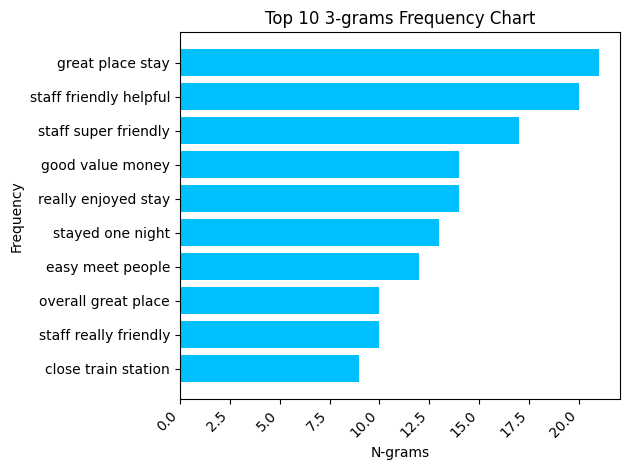

In [137]:
# fun_freqent_ngram(df=check_set2, top=10, n=3, num_columns=1, my_char='user_nationality_name', my_text='clean_text')
fun_freqent_ngram(df=check_set2, top=10, n=3, num_columns=1, my_text='clean_text')

In [122]:
check_set3 = my_final_df.loc[(my_final_df['review_rating_overall'] < 70) & (my_final_df['sentiment_predict'] == 1)]
print(check_set3.shape)
print(check_set3[['review_comment','review_rating_overall','sentiment_label', 'sentiment_predict']].head())

(106, 31)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       review_comment  review_rating_overall  sentiment_label  sentiment_predict
50                                                                                                                                                                                                                                                                                                                                                                                                                           

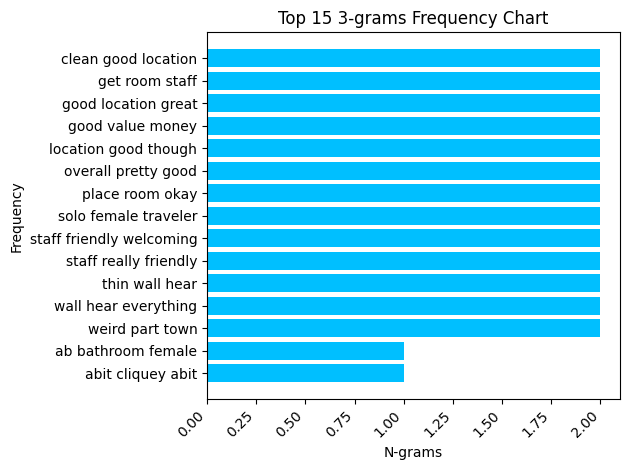

In [139]:
# fun_freqent_ngram(df=check_set3, top=10, n=3, num_columns=1, my_char='user_nationality_name', my_text='clean_text')
fun_freqent_ngram(df=check_set3, top=15, n=3, num_columns=1, my_text='clean_text')
# these comments look like truly negative

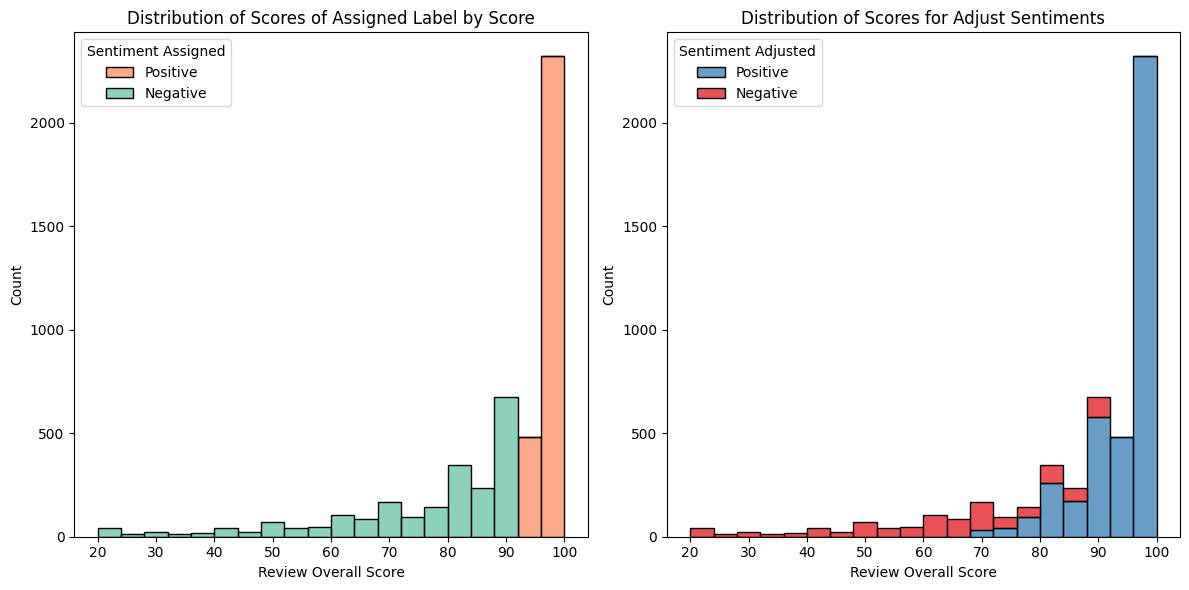

In [141]:
#for better recommendation, we'll manually change the sentiment label
# set label = True if overall score >=94; and set label = false if overall score <70
#my_final_df.head(1)
my_final_df['adjust_sentiment'] = my_final_df['sentiment_predict']
my_final_df.loc[(my_final_df['review_rating_overall'] >= 94) & (my_final_df['sentiment_predict'] == 0), 'adjust_sentiment'] = True
my_final_df.loc[(my_final_df['review_rating_overall'] < 70) & (my_final_df['sentiment_predict'] == 1), 'adjust_sentiment'] = False

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(my_final_df, x='review_rating_overall', hue='sentiment_label', bins=20, multiple='stack', palette='Set2', ax=axs[0])
axs[0].set_title('Distribution of Scores of Assigned Label by Score')
axs[0].set_xlabel('Review Overall Score')
axs[0].set_ylabel('Count')
axs[0].legend(title='Sentiment Assigned', labels=['Positive', 'Negative'])

sns.histplot(my_final_df, x='review_rating_overall', hue='adjust_sentiment', bins=20, multiple='stack', palette='Set1', ax=axs[1])
axs[1].set_title('Distribution of Scores for Adjust Sentiments')
axs[1].set_xlabel('Review Overall Score')
axs[1].set_ylabel('Count')
axs[1].legend(title='Sentiment Adjusted', labels=['Positive', 'Negative'])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [148]:
# my_final_df.to_csv(data_root + '/dataframe_final_results.csv')
print(my_final_df.head(3))
print(my_final_df.category_label.value_counts())

   C0              name    type  starRating            city.name city.country address review_date                                                                                                                                                                                                                                                                                                                                                                                                                                                     review_comment user_gender_code user_age   user_trip_code user_nationality_name   avg_score  review_rating_overall  sentiment_label Language2                                                                                                                                                                                                                                                                                                                                     